<a href="https://colab.research.google.com/github/YTW0415/Cybor_risk_prediction/blob/main/Kaggle_basket_20230315_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset 불러오기 - 태원's github 주소에서 불러오는거니 실제 수상 시 없애고 자기 깃허브 주소로 변경 바랍니다

In [4]:
!git clone https://github.com/YTW0415/Kaggle_Basketball.git

fatal: destination path 'Kaggle_Basketball' already exists and is not an empty directory.


# Adapting the 2nd Place Solution of the 2021 NCAAW Competition

- Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705
- 2nd place code : https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991
- It was adapted from this notebook : https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better 

**Changes :**
- Build one model for both Men and Women
- Update metric to MSE

In [5]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [6]:
DATA_PATH = '/content/Kaggle_Basketball/march-machine-learning-mania-2023_new/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

Cities.csv
Conferences.csv
Kenpom_score_0823.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals_thru_Season2023_Day128.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeam_fix.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv
kenpom0823.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [7]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [8]:
df_seeds['Seed'].value_counts()

W01     63
X14     63
Y01     63
Y02     63
Y03     63
        ..
Z13a     1
Z13b     1
Y12a     1
Y12b     1
Z14b     1
Name: Seed, Length: 90, dtype: int64

## Conference

In [9]:
df_conference = pd.concat([
    pd.read_csv(DATA_PATH + "MTeamConferences.csv"),
    pd.read_csv(DATA_PATH + "WTeamConferences.csv"),
], ignore_index=True)
    
df_conference.head()

,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac


## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [10]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [11]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [12]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [13]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [14]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [15]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [16]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [17]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [18]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [19]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [20]:
df_features_season.fillna(0, inplace=True)  

In [21]:
df_features_season = df_features_season.groupby(['TeamID','Season'])[df_features_season.columns[2:]].mean().reset_index()

In [22]:
df_features_season_3year = df_features_season.sort_values('Season').groupby(['TeamID'])[df_features_season.columns[2:]].rolling(3).mean().reset_index()

df_features_season_3year = df_features_season_3year[['NumWins','NumLosses','GapWins','GapLosses']]

df_features_season_3year.columns = df_features_season_3year.columns + '_3years'

df_features_season = pd.concat([df_features_season,df_features_season_3year],axis=1)

df_features_season.loc[df_features_season['NumWins_3years'].isnull(), df_features_season_3year.columns] = df_features_season.loc[df_features_season['NumWins_3years'].isnull(),df_features_season.iloc[:,2:6].columns].values

### Seed count add (0307)

In [23]:
df_features_season = df_features_season.merge(df_seeds, on=['Season', 'TeamID'], how='left').fillna('X0')

In [24]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_features_season['Seed'] = df_features_season['Seed'].apply(treat_seed)

In [25]:
# # Adding 1 to each season and averaging can help you find the number of seeds and tournament appearances over 5 years as of last year

# df_features_seed_3year = df_features_season.copy()

# df_features_seed_3year.loc[df_features_seed_3year['Seed'] > 0,'TourneyY'] = 1

# df_features_seed_3year.loc[df_features_seed_3year['Seed'] == 0,'TourneyY'] = 0

# df_features_seed_3year['Season'] = df_features_seed_3year['Season'] + 1

# df_features_seed_3year_1 = df_features_seed_3year.sort_values('Season').groupby(['TeamID'])['TourneyY'].rolling(3).sum().fillna(method='bfill').reset_index()

# # df_features_seed_3year_2 = df_features_seed_3year.sort_values('Season').groupby(['TeamID'])['Seed'].rolling(3).mean().fillna(method='bfill').reset_index()

# # df_features_seed_3year = pd.concat([df_features_seed_3year_1,df_features_seed_3year_2],axis=1)

# df_features_seed_3year_1.columns = df_features_seed_3year_1.columns + '_3years'

# df_features_seed_3year = df_features_seed_3year_1['TourneyY_3years']

# df_features_season = pd.concat([df_features_season,df_features_seed_3year],axis=1)

# #Three years of missing values based on the data start year, and new teams may also be missing. 
# #The new team wants to fill the missing values with zero and set the learning period to start in 2001.

# df_features_season.loc[df_features_season['TourneyY_3years'].isnull(), 'TourneyY_3years'] = 0

3년 동안 Seed 3 내에 들어온 팀의 경우 TopClass team으로 분류합니다

In [26]:
# Adding 1 to each season and averaging can help you find the number of seeds and tournament appearances over 5 years as of last year

df_features_seed_3year = df_features_season.copy()

df_features_seed_3year.loc[df_features_seed_3year['Seed'] > 0,'TourneyY'] = 1

df_features_seed_3year.loc[df_features_seed_3year['Seed'] == 0,'TourneyY'] = 0

df_features_seed_3year.loc[df_features_seed_3year['Seed'] < 3,'TopClassY'] = 1

df_features_seed_3year.loc[df_features_seed_3year['Seed'] == 0,'TopClassY'] = 0

df_features_seed_3year['Season'] = df_features_seed_3year['Season'] + 1

df_features_seed_3year_1 = df_features_seed_3year.sort_values('Season').groupby(['TeamID'])['TourneyY'].rolling(3).sum().fillna(method='bfill').reset_index()

df_features_seed_3year_2 = df_features_seed_3year.sort_values('Season').groupby(['TeamID'])['TopClassY'].rolling(3).sum().fillna(method='bfill').reset_index()

df_features_seed_3year = pd.concat([df_features_seed_3year_1,df_features_seed_3year_2],axis=1)

df_features_seed_3year.columns = df_features_seed_3year.columns + '_3years'

df_features_seed_3year = df_features_seed_3year[['TourneyY_3years','TopClassY_3years']]

df_features_season = pd.concat([df_features_season,df_features_seed_3year],axis=1)

#Three years of missing values based on the data start year, and new teams may also be missing. 
#The new team wants to fill the missing values with zero and set the learning period to start in 2001.

df_features_season.loc[df_features_season['TourneyY_3years'].isnull(), 'TourneyY_3years'] = 0

df_features_season.loc[df_features_season['TopClassY_3years'].isnull(), 'TopClassY_3years'] = 0

In [27]:
df_features_season['TourneyY_3years'].value_counts()

0.0    14108
1.0     3831
2.0     2017
3.0     1472
Name: TourneyY_3years, dtype: int64

Compute features

In [28]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)



In [29]:
df_features_season['WinRatio_3years'] = df_features_season['NumWins_3years'] / (df_features_season['NumWins_3years'] + df_features_season['NumLosses_3years'])
df_features_season['GapAvg_3years'] = (
    (df_features_season['NumWins_3years'] * df_features_season['GapWins_3years'] - 
    df_features_season['NumLosses_3years'] * df_features_season['GapLosses_3years'])
    / (df_features_season['NumWins_3years'] + df_features_season['NumLosses_3years'])
)

In [30]:
# df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

df_features_season.drop(df_features_season_3year.columns, axis=1, inplace=True)

In [31]:
df_features_season[df_features_season['Season'] == 2023].sort_values(by='WinRatio')

,TeamID,Season,NumWins,NumLosses,GapWins,GapLosses,Seed,TourneyY_3years,TopClassY_3years,WinRatio,GapAvg,WinRatio_3years,GapAvg_3years
19573,3389,2023,0.0,30.0,0.000000,18.766667,0,0.0,0.0,0.000000,-18.766667,0.292135,-8.887640
15380,3216,2023,0.0,26.0,0.000000,27.346154,0,0.0,0.0,0.000000,-27.346154,0.102941,-19.461277
17383,3298,2023,1.0,29.0,20.000000,18.034483,0,0.0,0.0,0.033333,-16.766667,0.219178,-7.942830
5276,1254,2023,1.0,26.0,4.000000,18.692308,0,0.0,0.0,0.037037,-17.851852,0.337838,-6.223627
21423,3473,2023,1.0,24.0,9.000000,18.500000,0,0.0,0.0,0.040000,-17.400000,0.040000,-17.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,1158,2023,30.0,3.0,14.966667,7.000000,12,1.0,0.0,0.909091,12.969697,0.658537,4.838967
4161,1222,2023,31.0,3.0,20.870968,5.666667,1,3.0,0.0,0.911765,18.529412,0.882979,17.821662
16493,3261,2023,28.0,2.0,29.178571,13.000000,3,2.0,0.0,0.933333,26.366667,0.756098,10.828737
20468,3424,2023,30.0,2.0,17.200000,16.000000,11,2.0,0.0,0.937500,15.125000,0.806818,9.456964


## Season Results - detail

- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WTO - turnovers committed (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- Possessions per game = Field goals attempted - offensive rebounds + turnovers + 0.475 x free throws attempted
---

- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

In [113]:
regseason_detail_df = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

regseason_detail_df.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [114]:
win_team_only = regseason_detail_df.drop(['LStl','WStl','LBlk','WBlk','LPF','WPF','DayNum'], axis=1)
win_team_only.rename(columns={'WTeamName': 'TeamName'}, inplace=True)
win_team_only.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
win_team_only.rename(columns={'LTeamID': 'OpponentTeamID'}, inplace=True)

team_factors_list = ['Score','FGM','FGA','FGA3','FGM3','TO','FTM','FTA','RankPOM','OR','DR','Ast']
for factor in team_factors_list:
    win_team_only.rename(columns={'W'+factor: factor}, inplace=True)
    win_team_only.rename(columns={'L'+factor: 'Opponent'+factor}, inplace=True)

win_team_only['wins'] = 1 

win_team_only = win_team_only[['Season','TeamID','wins','Score','OpponentScore',
                               'FGM','FGA','OpponentFGM','OpponentFGA','FGM3','FGA3',
                               'OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM',
                               'OpponentFTA','TO','OpponentTO','Ast','OpponentAst','DR','OpponentDR',
                               'OR','OpponentOR','OpponentTeamID']]

In [115]:
loss_team_only = regseason_detail_df.drop(['LStl','WStl','LBlk','WBlk','LPF','WPF','DayNum'], axis=1)
loss_team_only.rename(columns={'LTeamName': 'TeamName'}, inplace=True)
loss_team_only.rename(columns={'LTeamID': 'TeamID'}, inplace=True)
loss_team_only.rename(columns={'WTeamID': 'OpponentTeamID'}, inplace=True)

for factor in team_factors_list:
    loss_team_only.rename(columns={'L'+factor: factor}, inplace=True)
    loss_team_only.rename(columns={'W'+factor: 'Opponent'+factor}, inplace=True)

loss_team_only['wins'] = 0

loss_team_only = loss_team_only[['Season','TeamID','wins','Score','OpponentScore',
                               'FGM','FGA','OpponentFGM','OpponentFGA','FGM3','FGA3',
                               'OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM',
                               'OpponentFTA','TO','OpponentTO','Ast','OpponentAst','DR','OpponentDR',
                               'OR','OpponentOR','OpponentTeamID']]

In [116]:
reg_season_all = win_team_only.append(loss_team_only)

<ipython-input-116-5e14ad56bb83>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reg_season_all = win_team_only.append(loss_team_only)


In [117]:
reg_season_all['TOmargin'] = reg_season_all['TO']-reg_season_all['OpponentTO']

# Field Goal Rate
reg_season_all['FG'] = reg_season_all['FGM']/reg_season_all['FGA']
reg_season_all['FGopponent'] = reg_season_all['OpponentFGM']/reg_season_all['OpponentFGA']

# # Free Throw Rate
# reg_season_all['WFTRate'] = reg_season_all['FTA']/reg_season_all['FGA']
# reg_season_all['WFTRateopponent'] = reg_season_all['OpponentFTA']/reg_season_all['OpponentFGA']

# Free Throw Percentage
reg_season_all['FT'] = reg_season_all['FTM']/reg_season_all['FTA']

# FG3
reg_season_all['FG3'] = reg_season_all['FGM3']/reg_season_all['FGA3']
reg_season_all['FG3opponent'] = reg_season_all['OpponentFGM3']/reg_season_all['OpponentFGA3']

#Possession
reg_season_all['Possession'] = (reg_season_all['FGA'] -reg_season_all['OR'] +reg_season_all['TO'] + reg_season_all['FTA'] * 0.44) *0.96
reg_season_all['Possessionopponent'] = (reg_season_all['OpponentFGA'] -reg_season_all['OpponentOR'] +reg_season_all['OpponentTO'] + reg_season_all['OpponentFTA'] * 0.44)  *0.96

# Percentage of Field Goals Assisted
reg_season_all['AssistRate'] = reg_season_all['Ast'] / reg_season_all['FGM']
reg_season_all['AssistRateopponent'] = reg_season_all['OpponentAst'] / reg_season_all['OpponentFGM']

# Rebound Percentage
reg_season_all['ReboundPct'] = (reg_season_all['DR'] + reg_season_all['OR']) / (reg_season_all['OpponentFGA'] - reg_season_all['OpponentFGM'])
reg_season_all['ReboundPctopponent'] = (reg_season_all['OpponentDR'] + reg_season_all['OpponentOR']) / (reg_season_all['FGA'] - reg_season_all['FGM'])


In [118]:
pd.options.display.float_format = '{:.2f}'.format

reg_season_all.corr()['wins'].sort_values()

OpponentScore        -0.49
FGopponent           -0.48
OpponentFGM          -0.40
OpponentAst          -0.39
OpponentDR           -0.39
FG3opponent          -0.30
OpponentFTM          -0.30
TOmargin             -0.28
OpponentFTA          -0.27
AssistRateopponent   -0.19
OpponentFGM3         -0.19
TO                   -0.17
ReboundPct           -0.05
FGA3                 -0.04
Possession           -0.02
OpponentOR           -0.02
FGA                  -0.02
OpponentTeamID       -0.00
Season                0.00
TeamID                0.00
OpponentFGA           0.02
OR                    0.02
Possessionopponent    0.02
OpponentFGA3          0.04
ReboundPctopponent    0.05
FT                    0.14
OpponentTO            0.17
FGM3                  0.19
AssistRate            0.19
FTA                   0.27
FTM                   0.30
FG3                   0.30
DR                    0.39
Ast                   0.39
FGM                   0.40
FG                    0.48
Score                 0.49
w

In [119]:
# 쓸모없는 것 드랍

reg_season_all = reg_season_all.drop(['TO','OpponentTO','FGM','FGA','OpponentFGA','OpponentFGM','FGM3','FGA3','OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM','OpponentFTA'], axis=1)

In [120]:
reg_season_all = reg_season_all.merge(reg_season_all.groupby(['TeamID','Season'])['Possession'].mean().reset_index(),
                                      on=['Season', 'TeamID'],
                                      suffixes=('', '_Average'))

#팀이 평균적으로 Possessionopponent를 얼마나 허용하는지
reg_season_all = reg_season_all.merge(reg_season_all.groupby(['OpponentTeamID','Season'])['Possessionopponent'].mean().reset_index(),
                                                              on=['OpponentTeamID', 'Season'],
                                                              suffixes=('', '_Average'))

### KenPom Score 추가
1. 1번 방법
- Adjusted Offensive Efficiency : (Points Scored / Possessions) * (Opponent Average Possessions / 100)
- Adjusted Defensive Efficiency = (Points Allowed / Possessions) * (Opponent Average Possessions / 100)
- Adjusted Efficiency Margin = Adjusted Offensive Efficiency - Adjusted Defensive Efficiency
- Expected Winning Percentage = (Adjusted Offensive Efficiency ^ 11.5) / [(Adjusted Offensive Efficiency ^ 11.5) + (Adjusted Defensive Efficiency ^ 11.5)]

2. 일반적인 방법
- Offensive Efficiency : (Points Scored / Possessions)
- Defensive Efficiency = (Points Allowed / Possessions)
- Efficiency Margin = Offensive Efficiency - Defensive Efficiency
- Expected Winning Percentage = (Points Scored)16.5/[Points Scored)16.5 + (Points Allowed)16.5)]


In [121]:
reg_season_all['AdjO'] = reg_season_all['Score'] / reg_season_all['Possession'] * 100 * reg_season_all['Possessionopponent'] / 100 

reg_season_all['AdjD'] = reg_season_all['OpponentScore'] / reg_season_all['Possession'] * 100 * reg_season_all['Possessionopponent'] / 100 

reg_season_all['AdjEM'] = reg_season_all['AdjO']  - reg_season_all['AdjD'] 


reg_season_all['AdjEWP'] = reg_season_all['AdjO'] ** 11.5  / (reg_season_all['AdjO'] **11.5 + reg_season_all['AdjD']**11.5)

reg_season_all['OE'] = reg_season_all['Score'] / reg_season_all['Possession'] * 100

reg_season_all['DE'] = reg_season_all['OpponentScore'] / reg_season_all['Possession'] * 100

reg_season_all['EM'] = reg_season_all['OE']  - reg_season_all['DE'] 

reg_season_all['EWP'] = reg_season_all['Score']**16.5 /(reg_season_all['Score']**16.5  + reg_season_all['OpponentScore']**16.5) 

In [122]:
reg_season_all = reg_season_all.drop('OpponentTeamID',axis=1)

In [123]:
reg_season_all.columns

Index(['Season', 'TeamID', 'wins', 'Score', 'OpponentScore', 'Ast',
       'OpponentAst', 'DR', 'OpponentDR', 'OR', 'OpponentOR', 'TOmargin', 'FG',
       'FGopponent', 'FT', 'FG3', 'FG3opponent', 'Possession',
       'Possessionopponent', 'AssistRate', 'AssistRateopponent', 'ReboundPct',
       'ReboundPctopponent', 'Possession_Average',
       'Possessionopponent_Average', 'AdjO', 'AdjD', 'AdjEM', 'AdjEWP', 'OE',
       'DE', 'EM', 'EWP'],
      dtype='object')

In [124]:
reg_season_means = reg_season_all.groupby(['TeamID','Season']).mean().reset_index()

In [125]:
reg_season_means = reg_season_means.drop(['wins'], axis=1)

In [126]:
reg_season_sum = reg_season_all.groupby(['TeamID','Season']).sum().reset_index()

In [127]:
reg_season_sum = reg_season_sum.drop(['Score','OpponentScore','TOmargin','FG','FG3','FGopponent','FG3opponent','FT',
                                      'OR','OpponentOR',
                                      'Possession','Possessionopponent','Possession_Average','Possessionopponent_Average',
                                      'AdjO','AdjD','AdjEM','AdjEWP',
                                      'OE','DE','EM','EWP',
                                      'AssistRate','AssistRateopponent',
                                      'ReboundPct','ReboundPctopponent'], axis=1)

In [128]:
regseason_df = pd.merge(reg_season_means, reg_season_sum, left_on=['TeamID','Season'], right_on = ['TeamID','Season'], how='left')

In [129]:
regseason_df.head()

,TeamID,Season,Score,OpponentScore,Ast_x,OpponentAst_x,DR_x,OpponentDR_x,OR,OpponentOR,TOmargin,FG,FGopponent,FT,FG3,FG3opponent,Possession,Possessionopponent,AssistRate,AssistRateopponent,ReboundPct,ReboundPctopponent,Possession_Average,Possessionopponent_Average,AdjO,AdjD,AdjEM,AdjEWP,OE,DE,EM,EWP,wins,Ast_y,OpponentAst_y,DR_y,OpponentDR_y
0,1101,2014,63.14,78.62,10.00,15.57,20.33,24.10,8.00,10.38,2.86,0.41,0.51,0.76,0.38,0.37,63.81,63.88,0.48,0.57,1.10,1.19,63.81,65.24,63.10,78.77,-15.66,0.18,98.50,123.51,-25.01,0.15,2,210,327,427,506
1,1101,2015,61.00,71.86,11.86,12.93,19.64,25.89,8.25,10.04,-0.64,0.41,0.49,0.74,0.38,0.37,61.52,61.71,0.56,0.51,1.10,1.18,61.52,63.58,61.23,72.14,-10.90,0.29,98.38,117.03,-18.65,0.28,7,332,362,550,725
2,1101,2016,69.85,76.26,12.89,12.85,22.52,25.22,8.19,8.59,-0.04,0.44,0.49,0.70,0.36,0.37,65.97,66.72,0.54,0.48,1.15,1.14,65.97,67.35,70.74,77.16,-6.42,0.37,105.66,115.74,-10.07,0.36,9,348,347,608,681
3,1101,2017,67.88,72.64,13.60,13.60,22.88,25.04,7.56,10.64,-0.32,0.46,0.46,0.64,0.37,0.35,65.67,65.58,0.56,0.54,1.07,1.27,65.67,67.41,67.81,72.55,-4.74,0.38,103.28,110.64,-7.36,0.37,9,340,340,572,626
4,1101,2018,70.67,72.81,13.89,12.04,23.22,25.04,9.04,9.93,-1.07,0.45,0.46,0.71,0.33,0.32,67.26,67.36,0.54,0.49,1.11,1.15,67.26,67.91,70.77,72.91,-2.14,0.45,105.34,108.52,-3.18,0.45,12,375,325,627,676


## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [130]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [50]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
3895,2022,146,1242,76,1274,50
3896,2022,146,1314,69,1389,49
3897,2022,152,1242,81,1437,65
3898,2022,152,1314,81,1181,77


## FiveThirtyEight Ratings
> Not available yet !

In [131]:
# df_538 = pd.read_csv("../input/ncaa-men-538-team-ratings/538ratingsMen.csv")
# df_538.drop('TeamName', axis=1, inplace=True)
# df_538.head()

## Kenpom

Kenpom 정보를 크롤링했으나 남자팀만 존재하여 실제로는 Kenpom의 공식에 따라 값을 구하였음. 구하는 방법이 일부 틀릴 수 있음 (특히 Lucky)

https://github.com/harmkenn/Python_Madness_2023/blob/58ed1e5876817bf4e65ba4bf05b59fb3fa1e4cfd/notebooks/step01_aScrapeKenPom.ipynb

In [132]:
# # Grab KenPom 2008 to 2022

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# import pandas as pd
# import numpy as np
# from tqdm import tqdm

# season = np.arange(2008,2023,1)
# allkp = pd.DataFrame(columns = ['Year','Team','Conf','AdjEM','AdjO','AdjD','AdjT','Lucky','SOSEM','SOSO','SOSD'])
# for y in season:
#     req = Request(
#         url=f'https://kenpom.com/index.php?y={y}', 
#         headers={'User-Agent': 'Mozilla/5.0'}
#     )
#     webpage = urlopen(req).read()
#     soup =BeautifulSoup(webpage, 'html.parser')

#     table = soup.find('table', class_=None)
    
#     for row in tqdm(table.tbody.find_all('tr')):    
#         # Find all data for each column
#         columns = row.find_all('td')
        
#         if(columns != []):
            
#             Team = columns[1].text.strip()
#             Conf = columns[2].text.strip()
            
#             AdjEM = columns[4].text.strip()
#             AdjO = columns[5].text.strip()
#             AdjD = columns[7].text.strip()
#             AdjT = columns[9].text.strip()
#             Lucky = columns[11].text.strip()
#             SOSEM = columns[13].text.strip()
#             SOSO = columns[15].text.strip()
#             SOSD = columns[17].text.strip()
#             newrow = [y,Team,Conf,AdjEM,AdjO,AdjD,AdjT,Lucky,SOSEM,SOSO,SOSD]
#             allkp.loc[len(allkp)]=newrow
#             #newrow = pd.DataFrame({'Year':2008,'Team': Team,'Conf':Conf,'AdjEM':AdjEM,'AdjO':AdjO,'AdjD':AdjD,'AdjT':AdjT,'SOSEM':SOSEM,'SOSO':SOSO,'SOSD':SOSD})
#             #allkp = pd.concat(allkp,newrow)
#             allkp['Team'] = allkp['Team'].str.replace('\d+','',regex=True).str.replace('*','',regex=True).str.rstrip()

# allkp.to_csv('step01_kenpom0823.csv',index=False)

In [133]:
# # Grab KenPom 2023

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# import pandas as pd
# import numpy as np


# allkp = pd.read_csv('step01_kenpom0823.csv')
# allkp = allkp[allkp['Year']!=2023]
# y = 2023

# req = Request(
#     url=f'https://kenpom.com/index.php?y={y}', 
#     headers={'User-Agent': 'Mozilla/5.0'}
# )
# webpage = urlopen(req).read()
# soup =BeautifulSoup(webpage, 'html.parser')

# table = soup.find('table', class_=None)

# for row in table.tbody.find_all('tr'):    
#     # Find all data for each column
#     columns = row.find_all('td')
    
#     if(columns != []):
        
#         Team = columns[1].text.strip()
#         Conf = columns[2].text.strip()
        
#         AdjEM = columns[4].text.strip()
#         AdjO = columns[5].text.strip()
#         AdjD = columns[7].text.strip()
#         AdjT = columns[9].text.strip()
#         Lucky = columns[11].text.strip()
#         SOSEM = columns[13].text.strip()
#         SOSO = columns[15].text.strip()
#         SOSD = columns[17].text.strip()
#         newrow = [y,Team,Conf,AdjEM,AdjO,AdjD,AdjT,Lucky,SOSEM,SOSO,SOSD]
#         allkp.loc[len(allkp)]=newrow
#         #newrow = pd.DataFrame({'Year':2008,'Team': Team,'Conf':Conf,'AdjEM':AdjEM,'AdjO':AdjO,'AdjD':AdjD,'AdjT':AdjT,'SOSEM':SOSEM,'SOSO':SOSO,'SOSD':SOSD})
#         #allkp = pd.concat(allkp,newrow)
#         allkp['Team'] = allkp['Team'].str.replace('\d+','',regex=True).str.replace('*','',regex=True).str.rstrip()


# allkp.to_csv('Kenpom_score_0823.csv',index=False)

In [134]:
Kenpom_df = pd.read_csv(DATA_PATH + 'Kenpom_score_0823.csv')

Kenpom_df.columns = Kenpom_df.columns + '_kenpom'

man_team = pd.read_csv(DATA_PATH + 'MTeams.csv')

man_team_fix = pd.read_csv(DATA_PATH + 'MTeam_fix.csv')

LF = list(man_team_fix['tofix'])

LR = list(man_team_fix['replacewith'])

Kenpom_df['Team_kenpom'] = Kenpom_df['Team_kenpom'].replace(LF,LR)

In [55]:
Kenpom_df = Kenpom_df.merge(man_team, left_on = 'Team_kenpom',right_on = 'TeamName')

In [56]:
Kenpom_df = Kenpom_df[['TeamID','Year_kenpom',
                       #'Conf_kenpom',
                       'AdjEM_kenpom','AdjO_kenpom','AdjD_kenpom','AdjT_kenpom','Lucky_kenpom',
                       'SOSEM_kenpom','SOSO_kenpom','SOSD_kenpom']].rename(columns = {'Year_kenpom':'Season'})

Kenpom_df['AdjEWP_kenpom'] = Kenpom_df['AdjO_kenpom'] / (Kenpom_df['AdjO_kenpom'] **11.5 + Kenpom_df['AdjD_kenpom'] **11.5)

In [57]:
regseason_df.merge(Kenpom_df, on = ['TeamID','Season'],how = 'left')

,TeamID,Season,Score,OpponentScore,OR,OpponentOR,TOmargin,FG,FGopponent,FG3,FG3opponent,FT,Possession,Possessionopponent,Possession_Average,Possessionopponent_Average,AdjO,AdjD,AdjEM,AdjEWP,OE,DE,EM,EWP,wins,AdjEM_kenpom,AdjO_kenpom,AdjD_kenpom,AdjT_kenpom,Lucky_kenpom,SOSEM_kenpom,SOSO_kenpom,SOSD_kenpom,AdjEWP_kenpom
0,1101,2014,63.14,78.62,8.00,10.38,2.86,0.41,0.51,0.38,0.37,0.76,63.81,63.88,63.81,65.24,63.10,78.77,-15.66,0.18,98.50,123.51,-25.01,0.15,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1101,2015,61.00,71.86,8.25,10.04,-0.64,0.41,0.49,0.38,0.37,0.74,61.52,61.71,61.52,63.58,61.23,72.14,-10.90,0.29,98.38,117.03,-18.65,0.28,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1101,2016,69.85,76.26,8.19,8.59,-0.04,0.44,0.49,0.36,0.37,0.70,65.97,66.72,65.97,67.35,70.74,77.16,-6.42,0.37,105.66,115.74,-10.07,0.36,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1101,2017,67.88,72.64,7.56,10.64,-0.32,0.46,0.46,0.37,0.35,0.64,65.67,65.58,65.67,67.41,67.81,72.55,-4.74,0.38,103.28,110.64,-7.36,0.37,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1101,2018,70.67,72.81,9.04,9.93,-1.07,0.45,0.46,0.33,0.32,0.71,67.26,67.36,67.26,67.91,70.77,72.91,-2.14,0.45,105.34,108.52,-3.18,0.45,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12141,3473,2023,54.64,72.04,6.36,10.64,5.56,0.39,0.46,0.30,0.26,0.69,66.27,67.01,66.27,68.92,55.34,72.99,-17.65,0.12,82.14,108.91,-26.78,0.09,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12142,3474,2023,57.12,71.73,8.46,9.42,-0.88,0.35,0.46,0.26,0.33,0.67,70.01,69.01,70.01,67.04,56.40,70.92,-14.52,0.20,81.72,102.41,-20.70,0.18,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12143,3475,2023,62.38,65.85,9.00,9.27,2.62,0.40,0.40,0.29,0.30,0.78,71.40,70.57,71.40,68.34,61.83,65.16,-3.33,0.42,87.42,92.19,-4.77,0.40,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12144,3476,2023,59.18,65.43,8.68,8.79,3.32,0.39,0.43,0.31,0.32,0.73,64.96,64.53,64.96,66.86,58.85,65.11,-6.26,0.36,91.22,101.00,-9.78,0.35,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Engineering

## Train data

In [177]:
# 여자부의 능력치가 있는 2013년 이후를 대상으로 모델 만들기

df = df_tourney_results.copy()
df = df[df['Season'] >= 2001].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2001,137,3155,51,3151,49
1,2001,137,3196,84,3221,52
2,2001,137,3199,72,3408,70
3,2001,137,3208,77,3251,48
4,2001,137,3235,100,3224,61


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [178]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [179]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [180]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [181]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2001,137,3155,51,3151,49,5,12
1,2001,137,3196,84,3221,52,3,14
2,2001,137,3199,72,3408,70,7,10
3,2001,137,3208,77,3251,48,2,15
4,2001,137,3235,100,3224,61,2,15


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [182]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
    'WinRatio_3years': 'WinRatio_3yearsW',
    'GapAvg_3years': 'GapAvg_3yearsW',
    'TourneyY_3years':'TourneyY_3yearsW',
    'TopClassY_3years':'TopClassY_3yearsW',
}).drop(columns='TeamID', axis=1)

In [183]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
    'WinRatio_3years': 'WinRatio_3yearsL',
    'GapAvg_3years': 'GapAvg_3yearsL',
    'TourneyY_3years':'TourneyY_3yearsL',
    'TopClassY_3years':'TopClassY_3yearsL',
}).drop(columns='TeamID', axis=1)

### Season Stats detail

In [184]:
df = pd.merge(
    df,
    regseason_df,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginW',
    'FG': 'FGW',
    'FGopponent': 'FGopponentW',
    'FG3': 'FG3W',
    'FG3opponent': 'FG3opponentW',
    'FT': 'FTW',
    'AdjO':'AdjOW',
    'AdjD':'AdjDW',
    'AdjEM':'AdjEMW',
    'AdjEWP':'AdjEWPW',
    'Possession':'PossessionW',
    'OE':'OEW',
    'DE':'DEW',
    'EM':'EMW',
    'EWP':'EWPW',
    'AssistRate':'AssistRateW',
    'ReboundPct':'ReboundPctW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    regseason_df,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginL',
    'FG': 'FGL',
    'FGopponent': 'FGopponentL',
    'FG3': 'FG3L',
    'FG3opponent': 'FG3opponentL',
    'FT': 'FTL',
    'AdjO':'AdjOL',
    'AdjD':'AdjDL',
    'AdjEM':'AdjEML',
    'AdjEWP':'AdjEWPL',
    'EWP':'EWPL',
    'Possession':'PossessionL',
    'OE':'OEL',
    'DE':'DEL',
    'EM':'EML',
    'EWP':'EWPL',
    'AssistRate':'AssistRateL',
    'ReboundPct':'ReboundPctL'
}).drop(columns='TeamID', axis=1)

In [185]:
# df = pd.merge(
#     df,
#     regseason_df,
#     how='left',
#     left_on=['Season', 'WTeamID'],
#     right_on=['Season', 'TeamID']
# ).rename(columns={
#     'TOmargin': 'TOmarginW',
#     'FG': 'FGW',
#     'FGopponent': 'FGopponentW',
#     'FG3': 'FG3W',
#     'FG3opponent': 'FG3opponentW',
#     'FT': 'FTW',
#     'AdjO_kenpom':'AdjOW',
#     'AdjD_kenpom':'AdjDW',
#     'AdjEM_kenpom':'AdjEMW',
#     'AdjEWP_kenpom':'AdjEWPW',
#     'Lucky_kenpom':'Lucky_kenpomW',
#     'Possession':'PossessionW',
#     'OE':'OEW',
#     'DE':'DEW',
#     'EM':'EMW',
#     'EWP':'EWPW'
# }).drop(columns='TeamID', axis=1)

# df = pd.merge(
#     df,
#     regseason_df,
#     how='left',
#     left_on=['Season', 'LTeamID'],
#     right_on=['Season', 'TeamID']
# ).rename(columns={
#     'TOmargin': 'TOmarginL',
#     'FG': 'FGL',
#     'FGopponent': 'FGopponentL',
#     'FG3': 'FG3L',
#     'FG3opponent': 'FG3opponentL',
#     'FT': 'FTL',
#     'AdjO_kenpom':'AdjOL',
#     'AdjD_kenpom':'AdjDL',
#     'AdjEM_kenpom':'AdjEML',
#     'AdjEWP_kenpom':'AdjEWPL',
#     'Lucky_kenpom':'Lucky_kenpomL',
#     'EWP':'EWPL',
#     'Possession':'PossessionL',
#     'OE':'OEL',
#     'DE':'DEL',
#     'EM':'EML',
#     'EWP':'EWPL'
# }).drop(columns='TeamID', axis=1)

### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [186]:
# df = pd.merge(
#     df,
#     df_538,
#     how='left',
#     left_on=['Season', 'WTeamID'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [187]:
# df = pd.merge(
#     df, 
#     df_538, 
#     how='left', 
#     left_on=['Season', 'LTeamID'], 
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [188]:
# df.head()

### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [189]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [190]:
df = add_loosing_matches(df)

### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [191]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', # '538rating'
    'FG','FG3','FT','TOmargin', # Custom stat
    'WinRatio_3years', 'GapAvg_3years','TourneyY_3years','TopClassY_3years',
    'AdjO','AdjD','AdjEM','AdjEWP',
    'OE','DE','EM','EWP',
    'Possession',
    'ReboundPct','AssistRate',
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

<ipython-input-191-a65f59eb2687>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']
<ipython-input-191-a65f59eb2687>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']
<ipython-input-191-a65f59eb2687>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-frag

In [192]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,NumWinsA,NumLossesA,GapWinsA,GapLossesA,Seed_x,TourneyY_3yearsA,TopClassY_3yearsA,WinRatioA,GapAvgA,WinRatio_3yearsA,GapAvg_3yearsA,NumWinsB,NumLossesB,GapWinsB,GapLossesB,Seed_y,TourneyY_3yearsB,TopClassY_3yearsB,WinRatioB,GapAvgB,WinRatio_3yearsB,GapAvg_3yearsB,Score_x,OpponentScore_x,Ast_x_x,OpponentAst_x_x,DR_x_x,OpponentDR_x_x,OR_x,OpponentOR_x,TOmarginA,FGA,FGopponentA,FTA,FG3A,FG3opponentA,PossessionA,Possessionopponent_x,AssistRateA,AssistRateopponent_x,ReboundPctA,ReboundPctopponent_x,Possession_Average_x,Possessionopponent_Average_x,AdjOA,AdjDA,AdjEMA,AdjEWPA,OEA,DEA,EMA,EWPA,wins_x,Ast_y_x,OpponentAst_y_x,DR_y_x,OpponentDR_y_x,Score_y,OpponentScore_y,Ast_x_y,OpponentAst_x_y,DR_x_y,OpponentDR_x_y,OR_y,OpponentOR_y,TOmarginB,FGB,FGopponentB,FTB,FG3B,FG3opponentB,PossessionB,Possessionopponent_y,AssistRateB,AssistRateopponent_y,ReboundPctB,ReboundPctopponent_y,Possession_Average_y,Possessionopponent_Average_y,AdjOB,AdjDB,AdjEMB,AdjEWPB,OEB,DEB,EMB,EWPB,wins_y,Ast_y_y,OpponentAst_y_y,DR_y_y,OpponentDR_y_y,SeedDiff,WinRatioDiff,GapAvgDiff,FGDiff,FG3Diff,FTDiff,TOmarginDiff,WinRatio_3yearsDiff,GapAvg_3yearsDiff,TourneyY_3yearsDiff,TopClassY_3yearsDiff,AdjODiff,AdjDDiff,AdjEMDiff,AdjEWPDiff,OEDiff,DEDiff,EMDiff,EWPDiff,PossessionDiff,ReboundPctDiff,AssistRateDiff
0,2001,137,3155,51,3151,49,5,12,20.00,9.00,17.10,15.00,5,3.00,0.00,0.69,7.14,0.71,8.32,24.00,6.00,20.25,14.17,12,1.00,0.00,0.80,13.37,0.68,6.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7,-0.11,-6.23,NaN,NaN,NaN,NaN,0.03,1.75,2.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,137,3196,84,3221,52,3,14,23.00,5.00,22.74,18.40,3,2.00,0.00,0.82,15.39,0.66,7.90,21.00,8.00,13.67,21.75,14,3.00,0.00,0.72,3.90,0.76,8.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11,0.10,11.50,NaN,NaN,NaN,NaN,-0.09,-0.30,-1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,137,3199,72,3408,70,7,10,18.00,11.00,16.67,12.00,7,1.00,0.00,0.62,5.79,0.44,0.32,22.00,9.00,15.18,9.11,10,3.00,0.00,0.71,8.13,0.80,10.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3,-0.09,-2.34,NaN,NaN,NaN,NaN,-0.36,-10.17,-2.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001,137,3208,77,3251,48,2,15,26.00,5.00,24.04,12.80,2,3.00,0.00,0.84,18.10,0.85,17.10,18.00,11.00,11.22,12.73,15,3.00,0.00,0.62,2.14,0.71,7.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13,0.22,15.96,NaN,NaN,NaN,NaN,0.14,9.44,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,137,3235,100,3224,61,2,15,25.00,5.00,20.92,9.20,2,3.00,0.00,0.83,15.90,0.81,15.10,20.00,9.00,18.80,20.56,15,1.00,0.00,0.69,6.59,0.64,4.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13,0.14,9.31,NaN,NaN,NaN,NaN,0.17,10.88,2.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,..

## Test Data

### Preparing

In [193]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")

In [194]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [195]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.50,2023,1101,1102
1,2023_1101_1103,0.50,2023,1101,1103
2,2023_1101_1104,0.50,2023,1101,1104
3,2023_1101_1105,0.50,2023,1101,1105
4,2023_1101_1106,0.50,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.50,2023,3474,3476
130679,2023_3474_3477,0.50,2023,3474,3477
130680,2023_3475_3476,0.50,2023,3475,3476
130681,2023_3475_3477,0.50,2023,3475,3477


### Seeds
- Seeds are not released yet, so I fill missing values with "W01"

In [196]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W17')

In [197]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W17')

In [198]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [199]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
    'WinRatio_3years': 'WinRatio_3yearsA',
    'GapAvg_3years': 'GapAvg_3yearsA',
    'TourneyY_3years':'TourneyY_3yearsA',
    'TopClassY_3years':'TopClassY_3yearsA',
}).drop(columns='TeamID', axis=1)

In [200]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
    'WinRatio_3years': 'WinRatio_3yearsB',
    'GapAvg_3years': 'GapAvg_3yearsB',
    'TourneyY_3years':'TourneyY_3yearsB',
    'TopClassY_3years':'TopClassY_3yearsB',
}).drop(columns='TeamID', axis=1)

#### Season detail

In [201]:
df_test = pd.merge(
    df_test,
    regseason_df,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginA',
    'FG': 'FGA',
    'FGopponent': 'FGopponentA',
    'FG3': 'FG3A',
    'FG3opponent': 'FG3opponentA',
    'FT': 'FTA',
    'AdjO':'AdjOA',
    'AdjD':'AdjDA',
    'AdjEM':'AdjEMA',
    'AdjEWP':'AdjEWPA',
    'Possession':'PossessionA',
    'OE':'OEA',
    'DE':'DEA',
    'EM':'EMA',
    'EWP':'EWPA',
    'AssistRate':'AssistRateA',
    'ReboundPct':'ReboundPctA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    regseason_df,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginB',
    'FG': 'FGB',
    'FGopponent': 'FGopponentB',
    'FG3': 'FG3B',
    'FG3opponent': 'FG3opponentB',
    'FT': 'FTB',
    'AdjO':'AdjOB',
    'AdjD':'AdjDB',
    'AdjEM':'AdjEMB',
    'AdjEWP':'AdjEWPB',
    'Possession':'PossessionB',
    'OE':'OEB',
    'DE':'DEB',
    'EM':'EMB',
    'EWP':'EWPB',
    'AssistRate':'AssistRateB',
    'ReboundPct':'ReboundPctB'

}).drop(columns='TeamID', axis=1)

In [202]:
# df_test = pd.merge(
#     df_test,
#     regseason_df,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).rename(columns={
#     'TOmargin': 'TOmarginA',
#     'FG': 'FGA',
#     'FGopponent': 'FGopponentA',
#     'FG3': 'FG3A',
#     'FG3opponent': 'FG3opponentA',
#     'FT': 'FTA',
#     'AdjO_kenpom':'AdjOA',
#     'AdjD_kenpom':'AdjDA',
#     'AdjEM_kenpom':'AdjEMA',
#     'AdjEWP_kenpom':'AdjEWPA',
#     'Lucky_kenpom':'Lucky_kenpomA',
#     'Possession':'PossessionA',
#     'OE':'OEA',
#     'DE':'DEA',
#     'EM':'EMA',
#     'EWP':'EWPA'
# }).drop(columns='TeamID', axis=1)

# df_test = pd.merge(
#     df_test,
#     regseason_df,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).rename(columns={
#     'TOmargin': 'TOmarginB',
#     'FG': 'FGB',
#     'FGopponent': 'FGopponentB',
#     'FG3': 'FG3B',
#     'FG3opponent': 'FG3opponentB',
#     'FT': 'FTB',
#     'AdjO_kenpom':'AdjOB',
#     'AdjD_kenpom':'AdjDB',
#     'AdjEM_kenpom':'AdjEMB',
#     'AdjEWP_kenpom':'AdjEWPB',
#     'Possession':'PossessionB',
#     'Lucky_kenpom':'Lucky_kenpomB',
#     'OE':'OEB',
#     'DE':'DEB',
#     'EM':'EMB',
#     'EWP':'EWPB'
# }).drop(columns='TeamID', axis=1)

### Ratings

In [203]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [204]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

### Differences

In [205]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

## Target

In [206]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

<ipython-input-206-ae49dc848448>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
<ipython-input-206-ae49dc848448>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['WinA'] = (df['ScoreDiff'] > 0).astype(int)


In [207]:
df['LuckyA'] = df['WinRatioA'] - df['EWPA']

df['LuckyB'] = df['WinRatioB'] - df['EWPB']

df['LuckyDiff'] = df['LuckyA'] -df['LuckyB']

<ipython-input-207-e9703642cecc>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['LuckyA'] = df['WinRatioA'] - df['EWPA']
<ipython-input-207-e9703642cecc>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['LuckyB'] = df['WinRatioB'] - df['EWPB']
<ipython-input-207-e9703642cecc>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

In [208]:
df_test['LuckyA'] = df_test['WinRatioA'] - df_test['EWPA']

df_test['LuckyB'] = df_test['WinRatioB'] - df_test['EWPB']

df_test['LuckyDiff'] = df_test['LuckyA'] -df_test['LuckyB']

### EDA

<AxesSubplot:xlabel='SeedA', ylabel='WinRatio_3yearsA'>

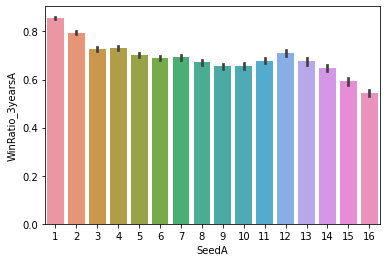

In [209]:
sns.barplot(x= 'SeedA',
            y='WinRatio_3yearsA',
            data = df,
            )

<AxesSubplot:xlabel='SeedA', ylabel='TourneyY_3yearsA'>

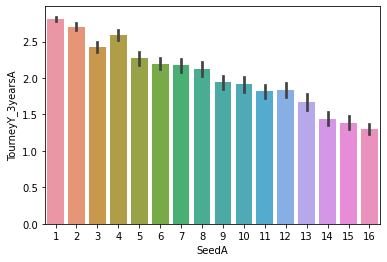

In [210]:
sns.barplot(x= 'SeedA',
            y='TourneyY_3yearsA',
            data = df,
            )

<AxesSubplot:xlabel='SeedA', ylabel='TopClassY_3yearsA'>

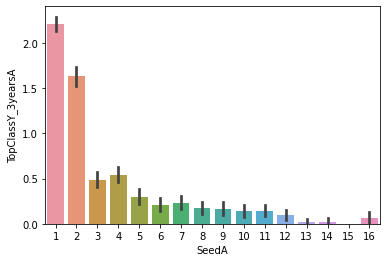

In [211]:
sns.barplot(x= 'SeedA',
            y='TopClassY_3yearsA',
            data = df,
            )

<AxesSubplot:xlabel='TopClassY_3yearsDiff', ylabel='WinA'>

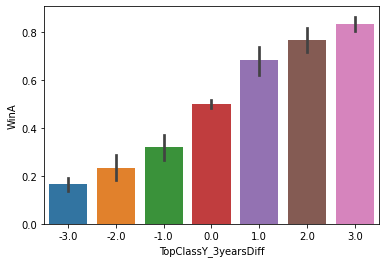

In [212]:
sns.barplot(x= 'TopClassY_3yearsDiff',
            y='WinA',
            data = df,
            )

<AxesSubplot:xlabel='TourneyY_3yearsDiff', ylabel='WinA'>

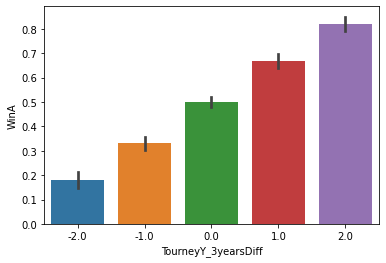

In [213]:
sns.barplot(x= 'TourneyY_3yearsDiff',
            y='WinA',
            data = df,
            )

<AxesSubplot:xlabel='SeedDiff', ylabel='WinA'>

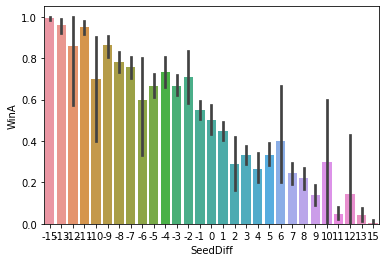

In [214]:
sns.barplot(x= 'SeedDiff',
            y='WinA',
            data = df,
            )

# Modeling

In [216]:
df.loc[df['TeamIdA'].astype('str').str.contains('^1',regex= True),'ManY'] = 1

df.loc[df['TeamIdA'].astype('str').str.contains('^3',regex= True),'ManY'] = 0

df['ManY'] = df['ManY'].astype('int')

<ipython-input-216-e5845387bec9>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['TeamIdA'].astype('str').str.contains('^1',regex= True),'ManY'] = 1


In [217]:
df_test.loc[df_test['TeamIdA'].astype('str').str.contains('^1',regex= True),'ManY'] = 1

df_test.loc[df_test['TeamIdA'].astype('str').str.contains('^3',regex= True),'ManY'] = 0

df_test['ManY'] = df_test['ManY'].astype('int')

#### Baseline

In [218]:
features = [
    'SeedA', 'SeedB',
    'SeedDiff',
    'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    'GapAvgA', 'GapAvgB',
    'GapAvgDiff',
    #'FGDiff',
    #'FGA','FGB',
    #'FG3Diff',
    #'FG3A','FG3B',
    #'FTDiff',
    #'FTA','FTB',
    #'TOmarginDiff',
    #'TOmarginA','TOmarginB'
]

In [219]:
# A하고 B 둘 중에 하나만 들어가야할 것 같음. 둘이 사실상 같은 변수임임

features = [
    #'SeedA', #'SeedB',
    'SeedDiff',
    'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    'GapAvgA', #'GapAvgB',
    'GapAvgDiff',
    'FGDiff',
    'FGA','FGB',
    'FG3Diff',
    'FG3A','FG3B',
    'FTDiff',
    'FTA','FTB',
    'TOmarginDiff',
    'TOmarginA','TOmarginB',
    'WinRatio_3yearsA', 'WinRatio_3yearsB',
    'WinRatio_3yearsDiff', 
    'GapAvg_3yearsA', 'GapAvg_3yearsB',
    'GapAvg_3yearsDiff',
    'AdjOA','AdjOB',
    'AdjODiff',
    'AdjDA', 'AdjDB',
    'AdjDDiff',
    'AdjEMA', 'AdjEMB',
    'AdjEMDiff',
    'LuckyA', 'LuckyB',
    'LuckyDiff',
    'TourneyY_3yearsA','TourneyY_3yearsB',
    'TourneyY_3yearsDiff',
    'TopClassY_3yearsDiff'
]

In [220]:
# A하고 B 둘 중에 하나만 들어가야할 것 같음. 둘이 사실상 같은 변수임임

features = [
    #'SeedA', 'SeedB',
    'SeedDiff',
    #'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    #'GapAvgA', #'GapAvgB',
    'GapAvgDiff',
    'FGDiff',
    #'FGA','FGB',
    'FG3Diff',
    #'FG3A','FG3B',
    'FTDiff',
    #'FTA','FTB',
    'TOmarginDiff',
    #'TOmarginA','TOmarginB',
    #'WinRatio_3yearsA', 'WinRatio_3yearsB',
    'WinRatio_3yearsDiff', 
    #'GapAvg_3yearsA', 'GapAvg_3yearsB',
    'GapAvg_3yearsDiff',
    #'AdjOA','AdjOB',
    #'AdjODiff',
    #'AdjDA', 'AdjDB',
    #'AdjDDiff',
    #'AdjEMA', 'AdjEMB',
    #'AdjEMDiff',
    #'AdjEWPA','AdjEWPB',
    #'AdjEWPDiff',
    #'LuckyA', 'LuckyB',
    'LuckyDiff',
    'TourneyY_3yearsA','TourneyY_3yearsB',
    'TourneyY_3yearsDiff',
    #'OEA','OB',
    'OEDiff',
    #'DA', 'DB',
    'DEDiff',
    #'EMA', 'EMB',
    'EMDiff',
    #'EWPA','EWPB',
    'EWPDiff',
    #'TopClassY_3yearsA','TopClassY_3yearsB',
    'TopClassY_3yearsDiff',
    'ManY'
]

In [221]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

### Baseline은 엘라스틱넷 회귀, 로지스틱 회귀

In [248]:
# Outlier

df = df[~((df['SeedDiff'] <= -9)&(df['WinA']== 0))]

df = df[~((df['SeedDiff'] >= 9)&(df['WinA']== 1))]

https://www.kaggle.com/code/sanandachowdhury/ncaa-march-madness-sabermetric-spin-v2

부팅은 여기서

In [252]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
#                 print( pred_test.max() - pred_test.min())
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests, cvs


Validating on season 2014


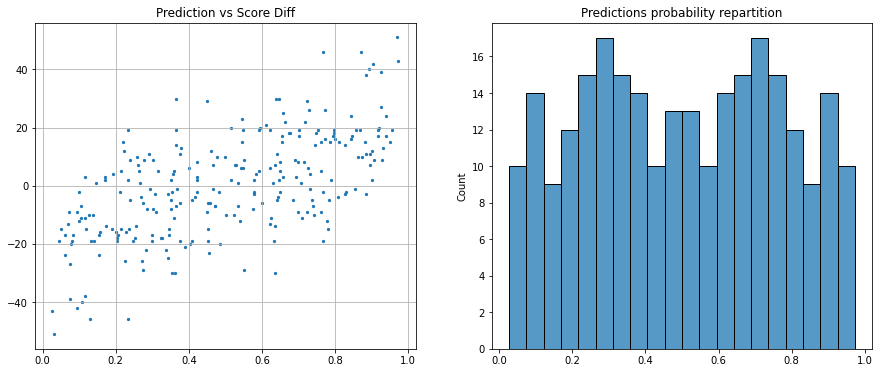

	 -> Scored 0.194

Validating on season 2015


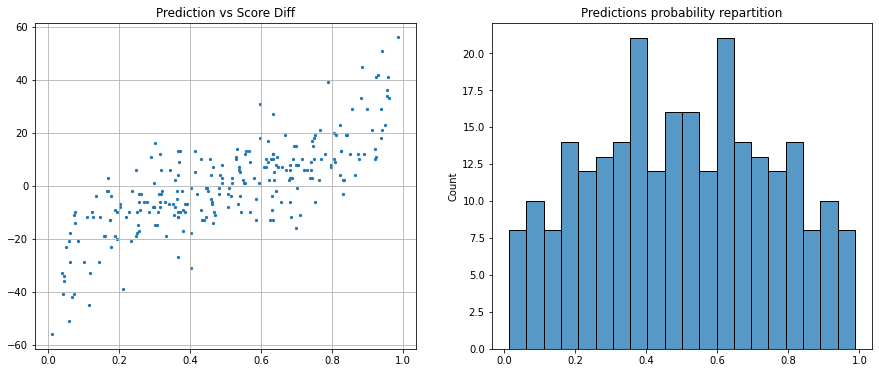

	 -> Scored 0.141

Validating on season 2016


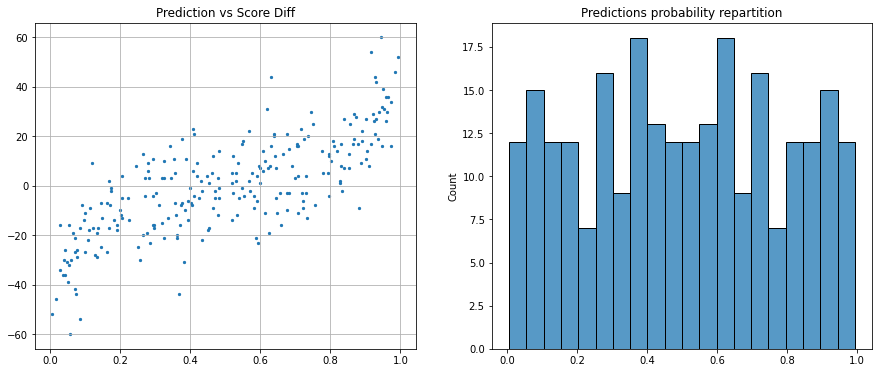

	 -> Scored 0.160

Validating on season 2017


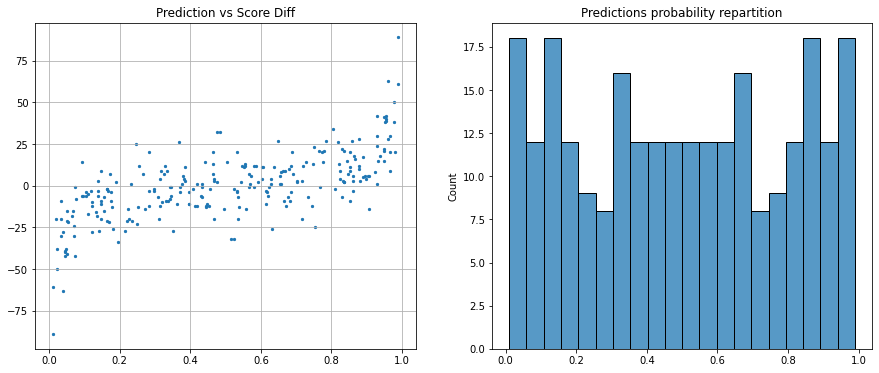

	 -> Scored 0.158

Validating on season 2018


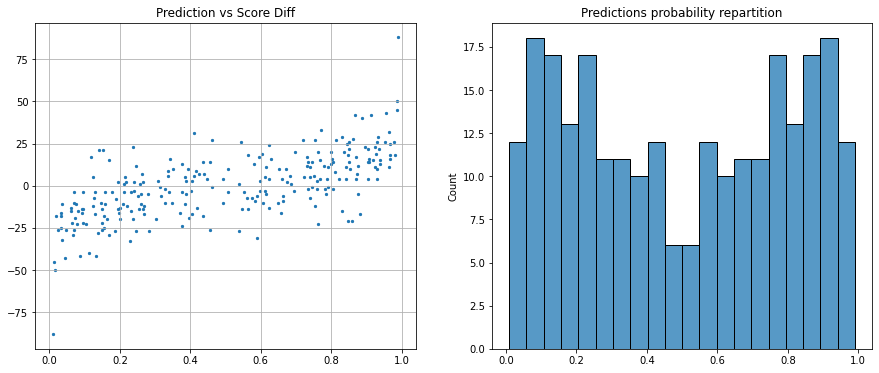

	 -> Scored 0.170

Validating on season 2019


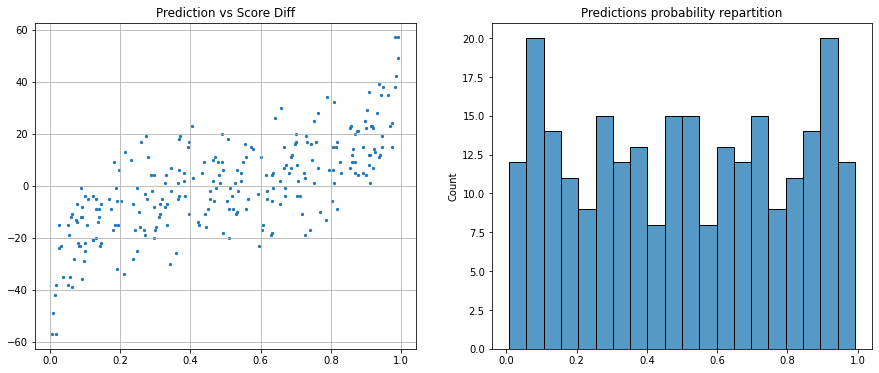

	 -> Scored 0.147

Validating on season 2021


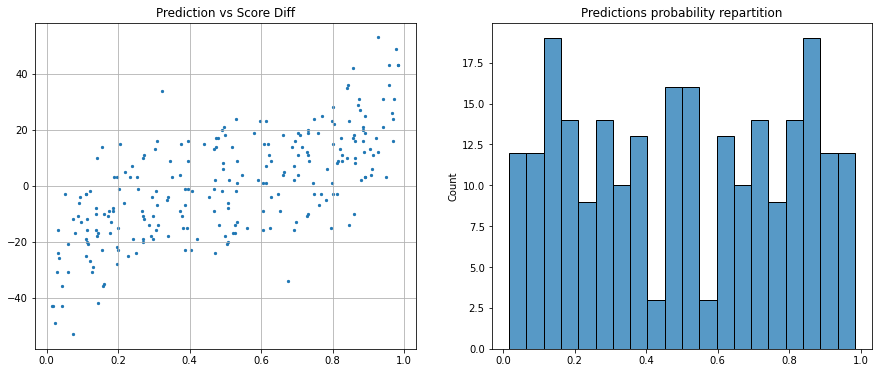

	 -> Scored 0.157

Validating on season 2022


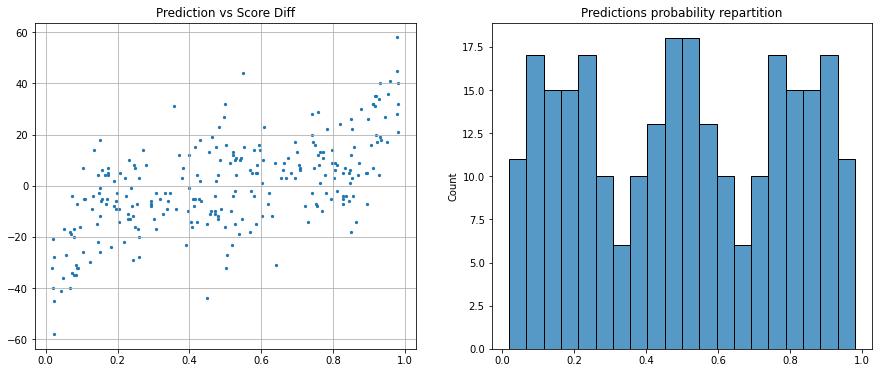

	 -> Scored 0.187

 Local CV is 0.164


In [253]:
pred_tests, cvs = kfold(df[df['Season'] >= 2013], df_test, plot=True, verbose=1, mode="cls")

## Submission

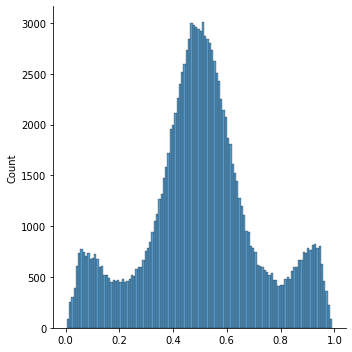

In [254]:
pred_test = np.mean(pred_tests, 0)
df_test['Pred'] = pred_test

final_sub = df_test[['ID', 'Pred']].copy()
final_sub.to_csv('/content/submission_baseline_0307.csv', index=False)

_ = sns.displot(pred_test)

### Brier Simulation

In [256]:
cd /content/Kaggle_Basketball/

/content/Kaggle_Basketball


In [257]:
import pandas as pd
from scipy import stats
from ncaa_simulator import Data, Submission, Tournament, round_names

## load data
mw = 'M' # or 'W'
ncaa_data = Data(mw, dir='/content/Kaggle_Basketball/march-machine-learning-mania-2023_new')

sub_df = pd.read_csv('/content/submission_baseline_0307.csv') # add your results as data to this notebook and edit this path to point to it

submission = Submission(sub_df=sub_df, data=ncaa_data)

season = 2023

tourney = Tournament(data=ncaa_data, submission=submission, season=season)

tourney.reset_tournament()

tourney.simulate_tournament(style='chalk') # this runs a chalk bracket where your predicted winner wins every game
# tourney.simulate_tournament(style='random',seed=123) # change the seed to get a different result

graph = tourney.graph_games()

graph.render('/content/Visual')

n_sim = 50

results, expected_losses = tourney.simulate_tournaments(n_sim=n_sim)

odds = results.copy()

odds.iloc[:,1:] = (results.iloc[:,1:]  / n_sim)

print(f'mean expected brier: {expected_losses.mean()} \n'
      f'standard dev brier: {expected_losses.std()} \n'
      f'standard error brier: {stats.sem(expected_losses)} \n')

odds.sort_values('Sweet 16', ascending=False).head(30)

mean expected brier: 0.18478508238529742 
standard dev brier: 0.020990736746604902 
standard error brier: 0.002109648420048905 



,Team,Play-in Games,First Round,Round of 32,Sweet 16,Elite 8,Final 4,Championship
TeamID,,,,,,,,
1222,Y01 - Houston,0.00,0.94,0.78,0.59,0.39,0.27,0.16
1400,Y02 - Texas,0.00,0.82,0.69,0.50,0.37,0.21,0.10
1112,X02 - Arizona,0.00,0.94,0.75,0.49,0.28,0.16,0.11
1345,W01 - Purdue,0.00,0.94,0.75,0.47,0.32,0.13,0.06
1104,X01 - Alabama,0.00,0.91,0.71,0.46,0.25,0.15,0.11
1266,W02 - Marquette,0.00,0.85,0.66,0.42,0.13,0.05,0.02
1417,Z02 - UCLA,0.00,0.91,0.68,0.40,0.21,0.12,0.08
1163,Z04 - Connecticut,0.00,0.82,0.63,0.37,0.22,0.09,0.02
1397,W04 - Tennessee,0.00,0.92,0.64,0.34,0.24,0.15,0.07


Done ! 

# AutoML

여기서부터가 가져온 게 아니라 실제로 만든 것, AutoML로 모델 구축

In [2]:
!pip install --use-deprecated=legacy-resolver pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 102.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
!pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainerdashboard 0.4.2.1 requires graphviz>=0.18.2, but you have graphviz 0.10.1 which is incompatible.
explainerdashboard 0.4.2.1 requires scikit-learn>=1.1, but you have scikit-learn 0.23.2 which is incompatible.


In [ ]:
# !pip uninstall sklearn -y
# !pip install --upgrade sklearn
# !pip install scikit-learn==0.2 --user

Found existing installation: sklearn 0.0.post1
Uninstalling sklearn-0.0.post1:
  Successfully uninstalled sklearn-0.0.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post1-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==0.2 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2)
ERROR: No matching distribution found for scikit-learn==0.2


#### Setup

In [258]:
train_df = pd.concat([df[df['Season'] >= 2013][features], df[df['Season'] >= 2013]['WinA']],axis=1)

test_df = df_test[features]

In [259]:
#Lucky이 상관계수는 낮은데 막상 모델에서 중요도가 좋게 나올때가 존재했음

train_df.corr()['WinA'].sort_values()

SeedDiff               -0.57
DEDiff                 -0.27
TourneyY_3yearsB       -0.26
TOmarginDiff           -0.14
LuckyDiff              -0.04
ManY                    0.00
FTDiff                  0.10
FG3Diff                 0.19
TourneyY_3yearsA        0.26
FGDiff                  0.34
WinRatioDiff            0.35
TourneyY_3yearsDiff     0.38
EWPDiff                 0.38
OEDiff                  0.39
TopClassY_3yearsDiff    0.41
WinRatio_3yearsDiff     0.41
EMDiff                  0.43
GapAvgDiff              0.43
GapAvg_3yearsDiff       0.45
WinA                    1.00
Name: WinA, dtype: float64

오류 생기면 런타임 재시작

In [260]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

pd.options.display.float_format = None

clf_test_1 = setup(data=train_df,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=10,
                   normalize = True,
                   transformation = False,
                   #pca = True,
                   #pca_components = 0.8,
                   feature_selection = False,
                   session_id = 4629,
                   silent=True,
                   #remove_outliers = True,
                   use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )

,Description,Value
0,session_id,4629
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2298, 20)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', '

In [261]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7fbf051313a0>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

In [262]:
# define Cauchy loss function for classification problems
def cauchy_loss_classification(y_true, y_pred):
    c = 2.0

    residual = (y_true - y_pred)
    
    loss = c**2 * np.log(1 + (residual**2) / c **2) /2
    
    return float(loss)

add_metric(id="my_metric", name="My Metric", score_func=cauchy_loss_classification, target="pred_proba", greater_is_better=False)

Name                                                         My Metric
Display Name                                                 My Metric
Score Function       <function cauchy_loss_classification at 0x7fbe...
Scorer               make_scorer(cauchy_loss_classification, greate...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: my_metric, dtype: object

### Blended Model

In [263]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)

custom_model = compare_models(fold = 10, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,My Metric,TT (Sec)
lr,Logistic Regression,0.7426,0.8361,0.7450,0.7414,0.7424,0.4852,0.4863,0.4929,0.1665,0.0,0.050
lda,Linear Discriminant Analysis,0.7395,0.8357,0.7412,0.7385,0.7392,0.4790,0.4799,0.4939,0.1670,0.0,0.021
catboost,CatBoost Classifier,0.7289,0.8314,0.7275,0.7290,0.7277,0.4578,0.4584,0.4872,0.1684,0.0,2.380
gbc,Gradient Boosting Classifier,0.7246,0.8284,0.7225,0.7251,0.7232,0.4491,0.4498,0.4892,0.1691,0.0,0.540
rf,Random Forest Classifier,0.7295,0.8233,0.7338,0.7270,0.7297,0.4591,0.4599,0.5049,0.1709,0.0,0.589
et,Extra Trees Classifier,0.7270,0.8216,0.7250,0.7267,0.7252,0.4541,0.4549,0.5065,0.1716,0.0,0.511
lightgbm,Light Gradient Boosting Machine,0.7189,0.8148,0.7200,0.7174,0.7182,0.4378,0.4384,0.5757,0.1917,0.0,0.158
xgboost,Extreme Gradient Boosting,0.7251,0.8176,0.7263,0.7230,0.7244,0.4502,0.4505,0.6325,0.1976,0.0,0.508
knn,K Neighbors Classifier,0.6984,0.7674,0.6900,0.7002,0.6947,0.3968,0.3973,1.6367,0.2012,0.0,0.192
ada,Ada Boost Classifier,0.7134,0.8160,0.7050,0.7189,0.7106,0.4267,0.4283,0.6059,0.2085,0.0,0.197


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4629, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), <catboost.core.CatBoostClassifier object at 0x7fbe3896b160>]
INFO:logs:compare_models() succesfully completed......................................


In [264]:

# # # 가장 좋은 모델에 대해 튜닝

# tuned_top = [tune_model(i, 
#                         optimize = 'Brier',
#                         #choose_better = True,
#                         #search_library = 'scikit-optimize'
#                         ) for i in custom_model]

In [265]:
# # 가장 좋은 모델에 대해 튜닝

tuned_top = [tune_model(i, 
                        optimize = 'Brier',
                        choose_better = True,
                        search_library = 'scikit-optimize'
                        ) for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,My Metric
Fold,,,,,,,,,,
0,0.7267,0.8125,0.7625,0.7093,0.7349,0.4536,0.4549,0.5091,0.1751,-0.0
1,0.7205,0.8097,0.7125,0.7215,0.7170,0.4409,0.4410,0.5163,0.1757,-0.0
2,0.7578,0.8534,0.7625,0.7531,0.7578,0.5155,0.5156,0.4710,0.1571,-0.0
3,0.7578,0.8514,0.7500,0.7595,0.7547,0.5155,0.5155,0.4754,0.1586,-0.0
4,0.7702,0.8790,0.7750,0.7654,0.7702,0.5404,0.5404,0.4518,0.1476,-0.0
5,0.7516,0.8461,0.6875,0.7857,0.7333,0.5027,0.5066,0.4834,0.1614,-0.0
6,0.6832,0.7769,0.7125,0.6706,0.6909,0.3667,0.3674,0.5450,0.1890,-0.0
7,0.6584,0.7758,0.6500,0.6582,0.6541,0.3167,0.3167,0.5481,0.1903,-0.0
8,0.7812,0.8717,0.7500,0.8000,0.7742,0.5625,0.5636,0.4533,0.1492,-0.0


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 5
INFO:logs:<catboost.core.CatBoostClassifier object at 0x7fbe39a6ab20>
INFO:logs:tune_model() succesfully completed......................................


https://data-newbie.tistory.com/755

In [266]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top,
                              fold = 10,
                              optimize = 'Brier',
                              choose_better=True)

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,My Metric
Fold,,,,,,,,,,
0,0.7081,0.8105,0.7625,0.6854,0.7219,0.4165,0.4192,0.5193,0.1792,-0.0
1,0.7081,0.8086,0.6750,0.7200,0.6968,0.4159,0.4167,0.5235,0.1788,-0.0
2,0.7453,0.8532,0.7625,0.7349,0.7485,0.4908,0.4911,0.4680,0.1569,-0.0
3,0.7578,0.8532,0.7875,0.7412,0.7636,0.5157,0.5167,0.4641,0.1559,-0.0
4,0.7826,0.8853,0.7750,0.7848,0.7799,0.5652,0.5652,0.4356,0.1411,-0.0
5,0.7453,0.8478,0.6875,0.7746,0.7285,0.4903,0.4934,0.4782,0.1602,-0.0
6,0.6957,0.7807,0.7375,0.6782,0.7066,0.3916,0.3931,0.5495,0.1913,-0.0
7,0.6460,0.7812,0.6375,0.6456,0.6415,0.2918,0.2919,0.5547,0.1935,-0.0
8,0.7688,0.8802,0.7500,0.7792,0.7643,0.5375,0.5379,0.4391,0.1435,-0.0


INFO:logs:create_model_container: 24
INFO:logs:master_model_container: 24
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.635111118976184,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_component

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,My Metric
0,Voting Classifier,0.7725,0.8597,0.7622,0.7824,0.7721,0.545,0.5452,0.4623,0.1545,0


In [267]:
#최종 모델
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.635111118976184,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                

In [268]:
#X has 6 features per sample; expecting 30 오류 생길 시 setup 부터 다시

import datetime

now = datetime.datetime.now()

save_model(final_model_custom, f"/content/Model_test_{datetime.datetime.now()}")

prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

predictions = predict_model(prep_pipe,
                            data=test_df,
                            raw_score=True)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.635111118976184,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                            

Transformation Pipeline and Model Successfully Saved


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                                  solver='lbfgs',
                                                                  tol=0.0001,
                                                      

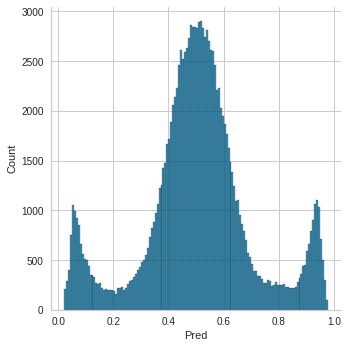

In [271]:
df_test_after_AutoML = df_test.copy()

df_test_after_AutoML['Pred'] = predictions['Score_1']

_ = sns.displot(df_test_after_AutoML['Pred'])

#### 최종 제출 파일

In [272]:
final_sub_after_AutoML = df_test_after_AutoML[['ID', 'Pred']].copy()

final_sub_after_AutoML.to_csv('/content/submission_total_0313.csv', index=False)

# Test : 실제 경기 결과 예측

In [273]:
%cd /content/Kaggle_Basketball/

/content/Kaggle_Basketball


In [274]:
import pandas as pd
from scipy import stats

from ncaa_simulator import Data, Submission, Tournament, round_names

## load data
mw = 'M' # or 'W'
ncaa_data = Data(mw, dir='/content/Kaggle_Basketball/march-machine-learning-mania-2023_new')

sub_df = pd.read_csv('/content/submission_total_0313.csv') # add your results as data to this notebook and edit this path to point to it

submission = Submission(sub_df=sub_df, data=ncaa_data)

season = 2023

tourney = Tournament(data=ncaa_data, submission=submission, season=season)

tourney.reset_tournament()

tourney.simulate_tournament(style='chalk') # this runs a chalk bracket where your predicted winner wins every game
# tourney.simulate_tournament(style='random',seed=123) # change the seed to get a different result

graph = tourney.graph_games()

graph.render('/content/Visual')

n_sim = 100

results, expected_losses = tourney.simulate_tournaments(n_sim=n_sim)

odds = results.copy()

odds.iloc[:,1:] = (results.iloc[:,1:]  / n_sim)

print(f'mean expected brier: {expected_losses.mean()} \n'
      f'standard dev brier: {expected_losses.std()} \n'
      f'standard error brier: {stats.sem(expected_losses)} \n')

odds.sort_values('Sweet 16', ascending=False).head(30)

mean expected brier: 0.17532914494126983 
standard dev brier: 0.02044312444622619 
standard error brier: 0.002054611313050736 



,Team,Play-in Games,First Round,Round of 32,Sweet 16,Elite 8,Final 4,Championship
TeamID,,,,,,,,
1112,X02 - Arizona,0.0,0.95,0.81,0.59,0.35,0.25,0.14
1222,Y01 - Houston,0.0,0.95,0.75,0.58,0.36,0.25,0.17
1266,W02 - Marquette,0.0,0.90,0.71,0.44,0.15,0.07,0.02
1345,W01 - Purdue,0.0,0.94,0.69,0.43,0.26,0.06,0.01
1104,X01 - Alabama,0.0,0.93,0.70,0.43,0.20,0.10,0.06
1163,Z04 - Connecticut,0.0,0.88,0.68,0.42,0.26,0.11,0.05
1400,Y02 - Texas,0.0,0.89,0.68,0.41,0.31,0.18,0.11
1417,Z02 - UCLA,0.0,0.93,0.66,0.39,0.19,0.12,0.09
1397,W04 - Tennessee,0.0,0.96,0.64,0.37,0.24,0.16,0.07


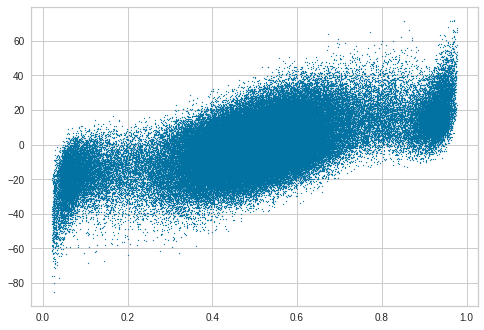

In [275]:
plt.scatter(final_sub_after_AutoML['Pred'],df_test['EMDiff'],s=1)

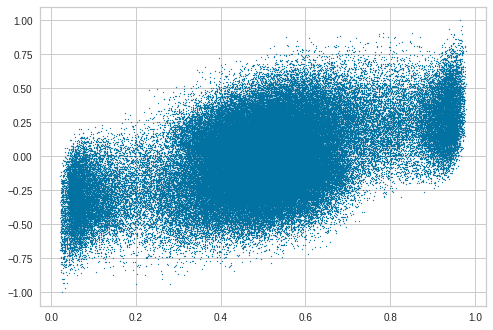

In [276]:
plt.scatter(final_sub_after_AutoML['Pred'],df_test['WinRatioDiff'],s=1)

In [277]:
final_sub_after_AutoML[final_sub_after_AutoML['Pred'] < 0.5]

,ID,Pred
2,2023_1101_1104,0.1018
8,2023_1101_1111,0.4973
9,2023_1101_1112,0.0742
13,2023_1101_1116,0.1467
16,2023_1101_1120,0.2707
...,...,...
130675,2023_3473_3476,0.4225
130676,2023_3473_3477,0.4599
130677,2023_3474_3475,0.3817
130678,2023_3474_3476,0.4022


In [278]:
predictions_train = predict_model(prep_pipe,
                                  data=train_df.iloc[:,:-1],
                                  raw_score=True)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                                  solver='lbfgs',
                                                                  tol=0.0001,
                                                      

In [279]:
predictions_train

,SeedDiff,WinRatioDiff,GapAvgDiff,FGDiff,FG3Diff,FTDiff,TOmarginDiff,WinRatio_3yearsDiff,GapAvg_3yearsDiff,LuckyDiff,...,TourneyY_3yearsDiff,OEDiff,DEDiff,EMDiff,EWPDiff,TopClassY_3yearsDiff,ManY,Label,Score_0,Score_1
756,-13,0.161290,7.838710,0.011621,-0.022894,-0.067737,2.612903,-0.072917,-1.754044,0.032125,...,-1.0,5.129283,-6.591123,11.720406,0.129165,0.0,0,1,0.0973,0.9027
757,-15,0.347538,32.332386,0.112299,0.039616,0.074102,-7.507331,0.458541,32.961168,-0.024299,...,2.0,26.778419,-21.679120,48.457539,0.371837,3.0,0,1,0.0228,0.9772
758,3,0.000000,-7.483871,0.011925,0.058287,0.054065,2.507230,-0.014184,-6.662189,0.029312,...,1.0,-3.393089,8.449535,-11.842624,-0.029312,0.0,0,0,0.6955,0.3045
759,-9,0.039785,3.724731,0.026178,-0.064790,-0.054303,-1.333333,0.132389,6.287287,0.008464,...,1.0,1.934776,-4.840258,6.775034,0.031321,0.0,0,1,0.0918,0.9082
760,-7,-0.101815,-4.995968,0.001743,-0.012840,0.185098,8.519153,-0.173644,-8.451006,0.006545,...,0.0,-0.398434,6.790671,-7.189105,-0.108359,0.0,0,1,0.3061,0.6939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,9,-0.126560,-6.653298,-0.002013,-0.009161,0.019261,-3.850267,-0.285714,-10.740999,-0.003199,...,-1.0,-1.891133,7.572918,-9.464051,-0.123361,0.0,1,0,0.8963,0.1037
2699,7,-0.106583,-1.856844,-0.028112,-0.016148,-0.080351,-1.770115,-0.000507,-0.740888,-0.037620,...,-1.0,-11.244405,-9.029790,-2.214616,-0.068963,0.0,1,0,0.7153,0.2847
2700,1,-0.035651,-0.895722,-0.040517,0.008975,0.088658,-2.274510,-0.045745,-1.944668,-0.006631,...,0.0,1.199518,0.238063,0.961455,-0.029020,0.0,1,0,0.5148,0.4852
2701,-6,0.096257,7.241533,0.034826,-0.003923,-0.038795,-2.254902,0.145828,7.590550,-0.011100,...,-1.0,7.582807,-3.121107,10.703914,0.107356,1.0,1,1,0.2025,0.7975


In [280]:
# #모델 불러오기

# load_model = load_model("/content/Model_test_2023-03-05")

# predictions = predict_model(load_model,
#                             data=test_df)

### Test : 각년도별로 test

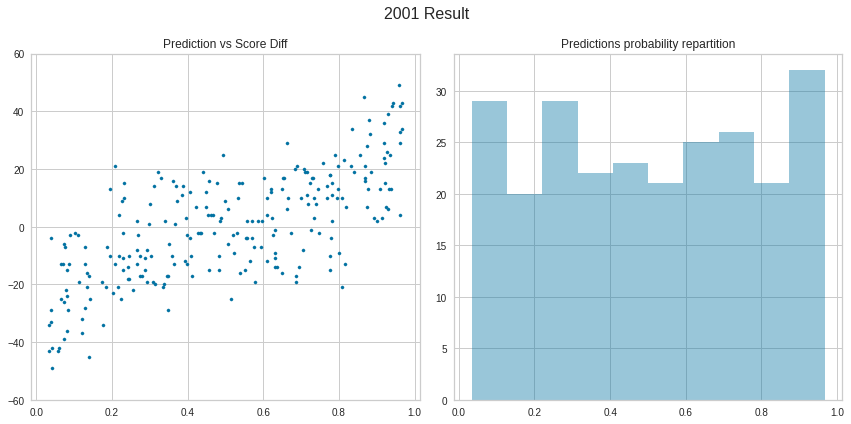

2001 Score :  0.15931239881357825


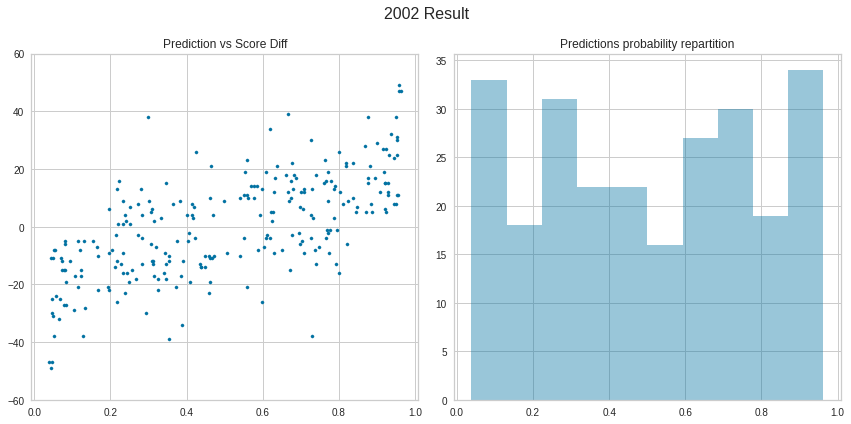

2002 Score :  0.17097375744218105


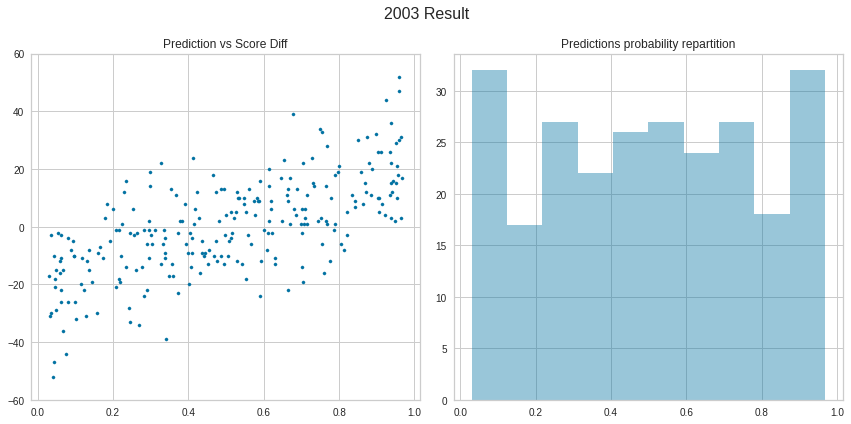

2003 Score :  0.15058511330132496


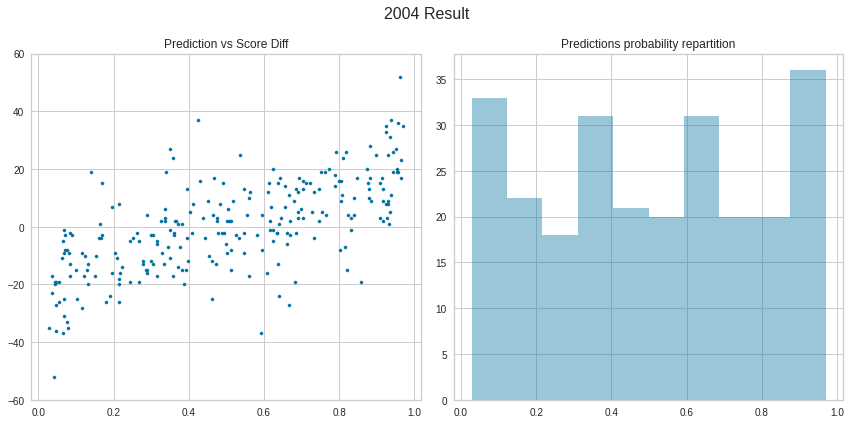

2004 Score :  0.15288820395493638


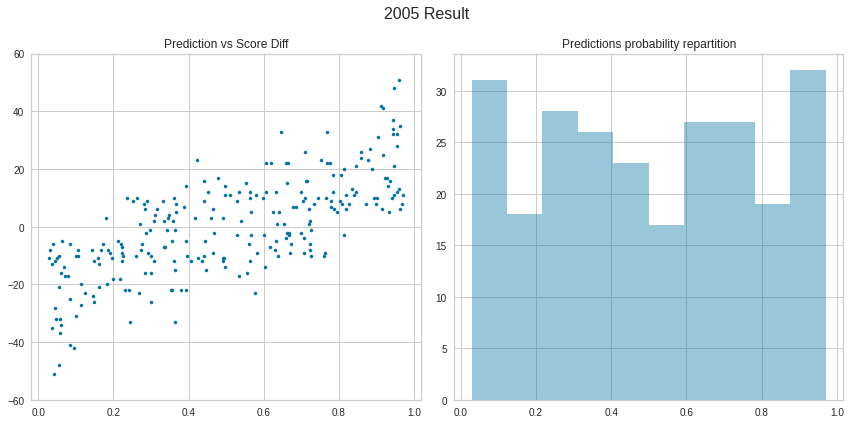

2005 Score :  0.15445935215334014


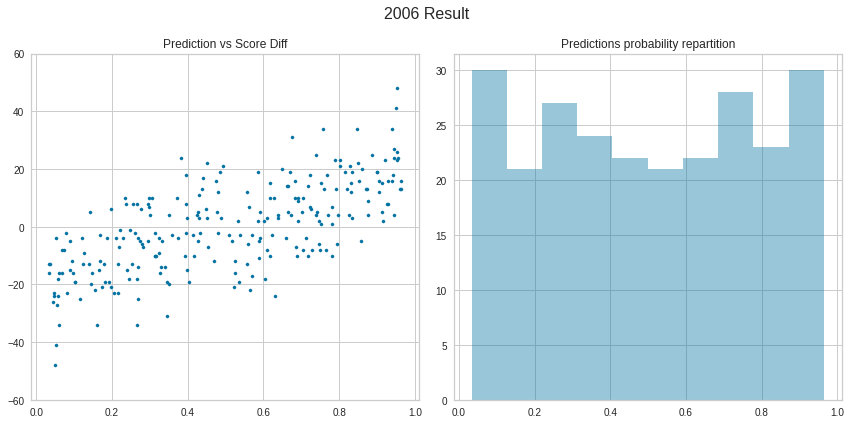

2006 Score :  0.15247258592353616


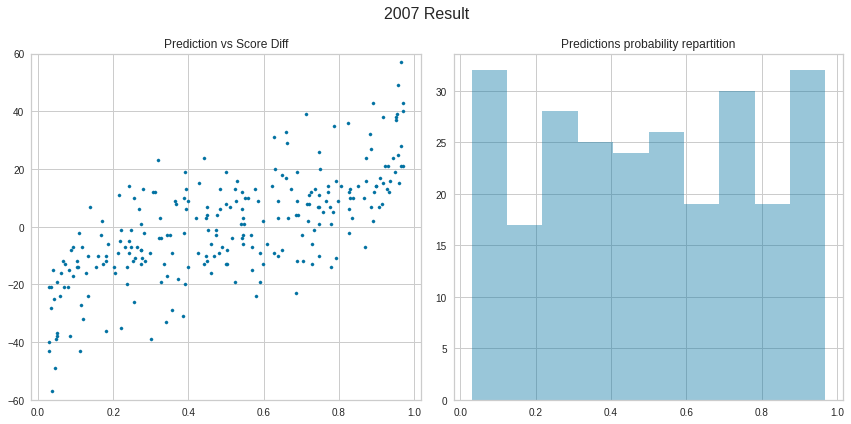

2007 Score :  0.15249001798427425


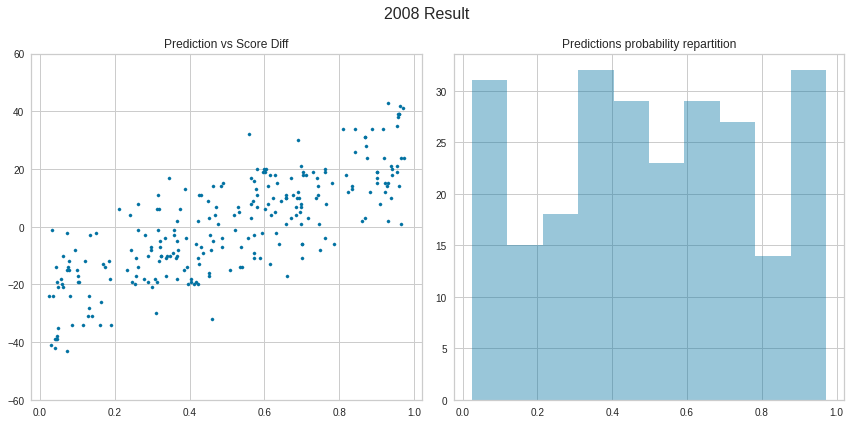

2008 Score :  0.12918428387766817


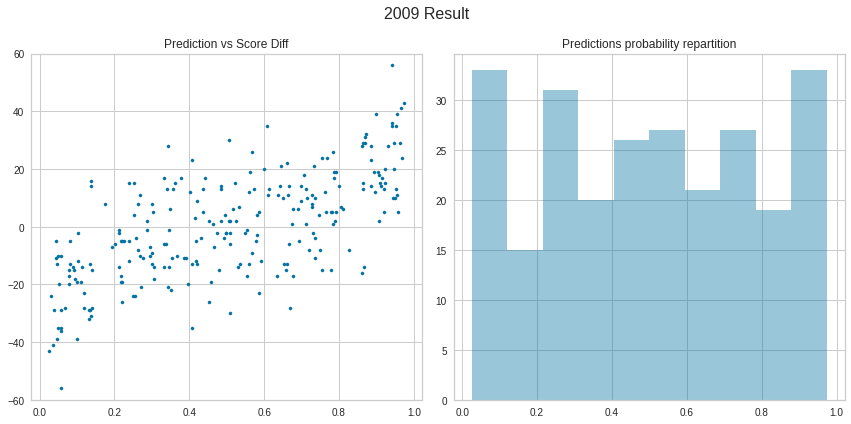

2009 Score :  0.15942587832625513


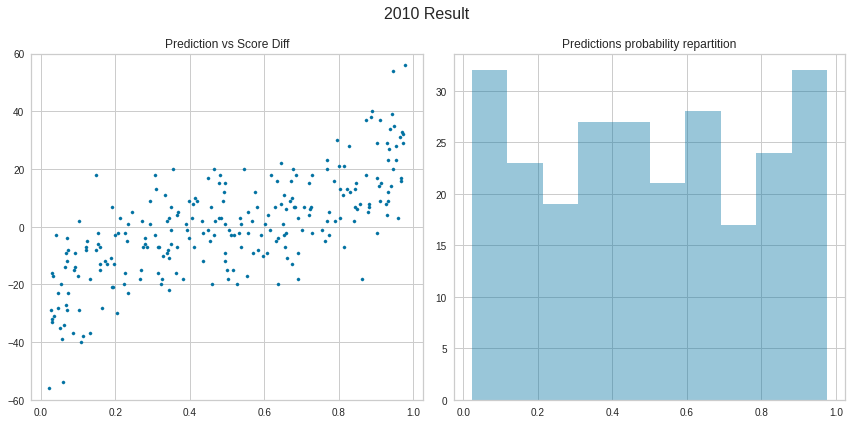

2010 Score :  0.1601910223425507


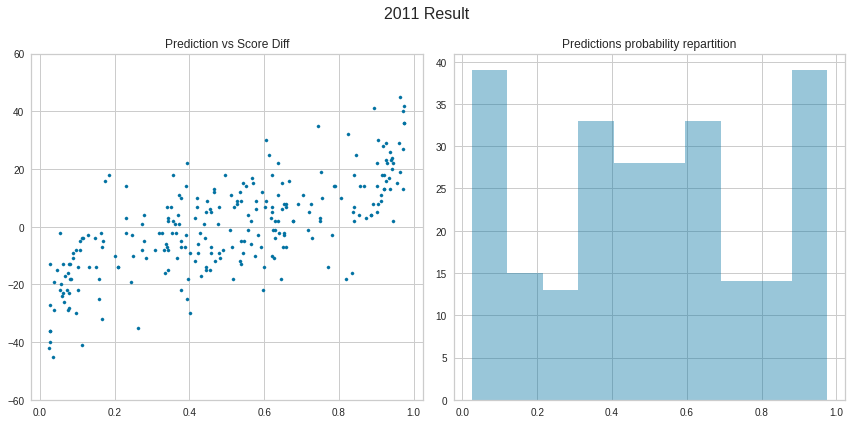

2011 Score :  0.15345158193879957


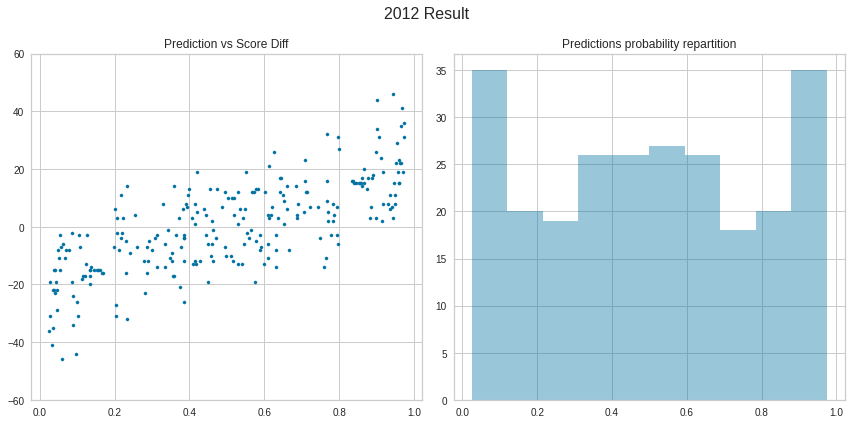

2012 Score :  0.13785224565083637


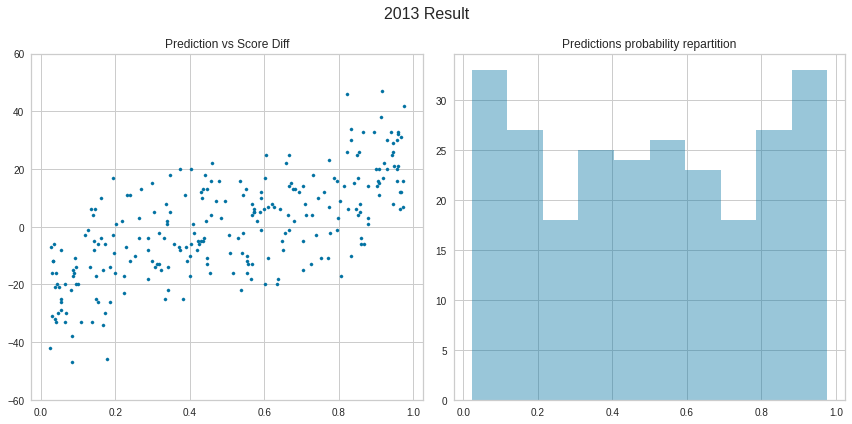

2013 Score :  0.165824728753877


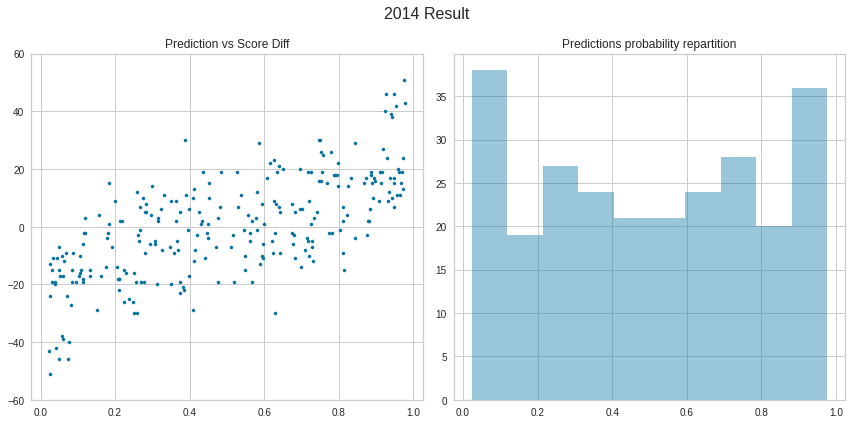

2014 Score :  0.1737472209585817


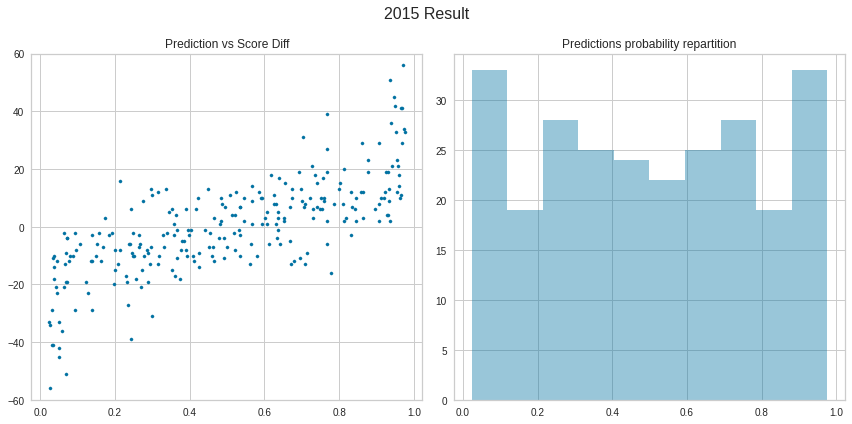

2015 Score :  0.12806612677389134


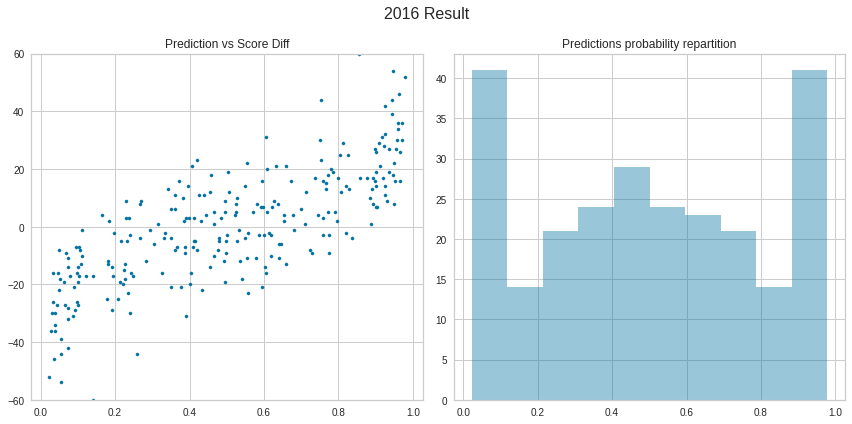

2016 Score :  0.14781027757612725


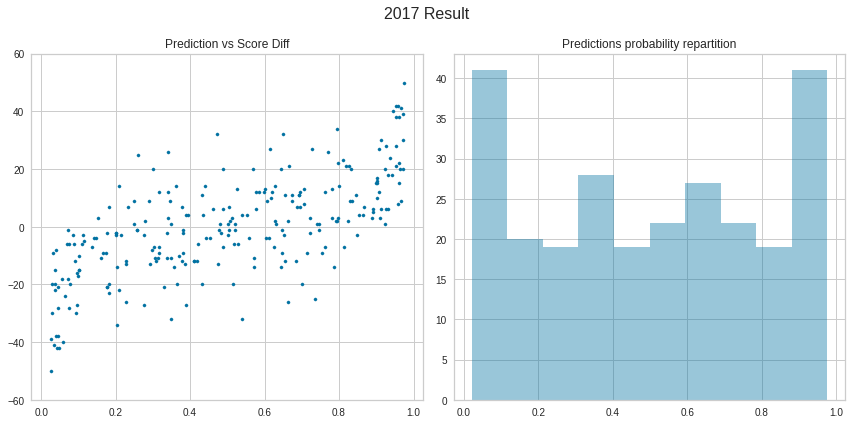

2017 Score :  0.14590814978087935


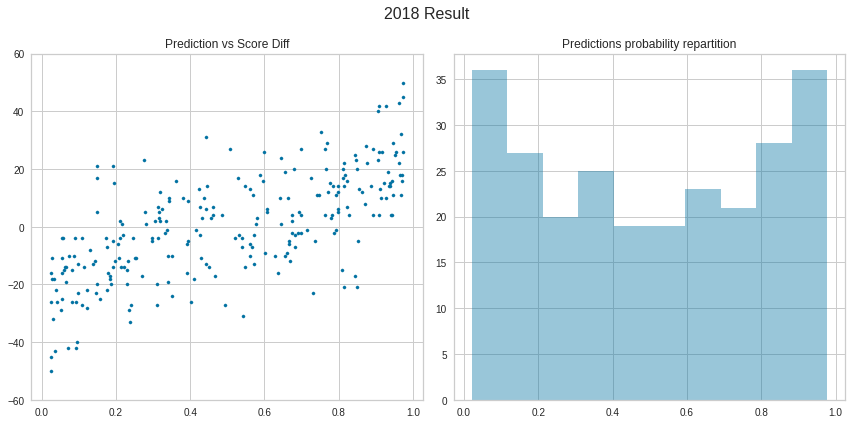

2018 Score :  0.15966656254240064


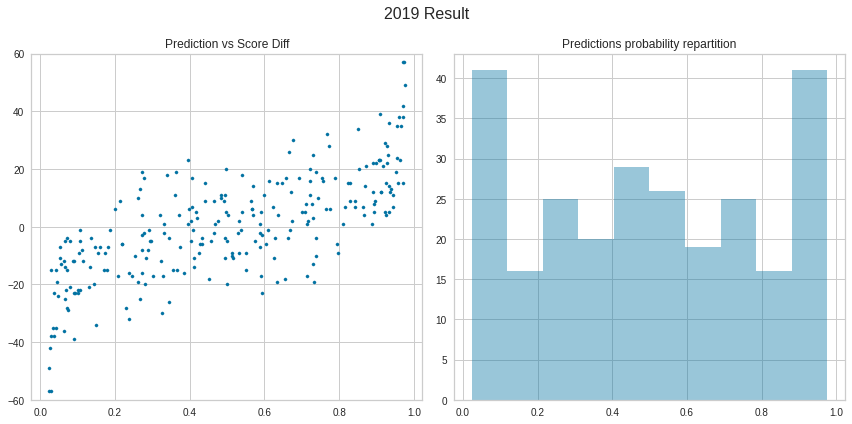

2019 Score :  0.13815742495951783


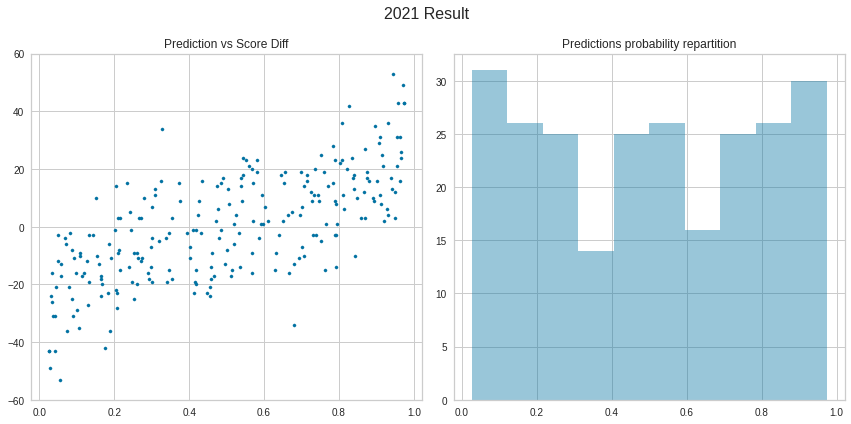

2021 Score :  0.14848504147590208


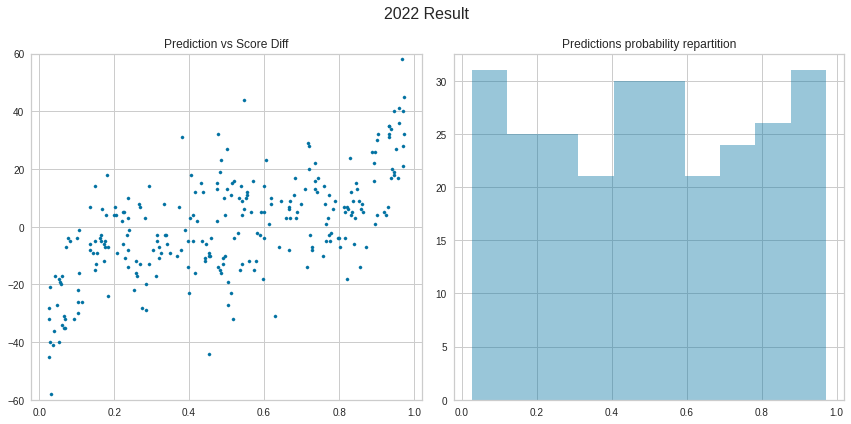

2022 Score :  0.17834628930201737


In [281]:
for year in df['Season'].unique():

  df_val = df[df['Season'] == year]

  df_val = df_val.reset_index(drop=True)

  prediction = prep_pipe.predict_proba(df_val[features])

  i, j = [], []
  for row in prediction:
    i.append(row[0])
    j.append(row[1])

  len(i), len(j)

  df_val['pred'] = j

  df_val['WinA_pred'] = prep_pipe.predict(df_val[features])
  
  #plt.figure(figsize=(12, 6))
  fig, ax = plt.subplots(1, 2,figsize = [12, 6])
  ax[0].set_ylim(-60, 60)
  ax[0].scatter(df_val['pred'], df_val['ScoreDiff'].values, s=10)
  ax[0].set_title('Prediction vs Score Diff')

  ax[1].hist(df_val['pred'], bins = 10, alpha = 0.4)
  ax[1].set_title('Predictions probability repartition')

  fig.suptitle(f'{year} Result', fontsize=16) # figure 제목

  fig.tight_layout() # 사용하면 플롯간 여백을 조정해준다. 
  plt.show()
  
  print(f'{year} Score : ', brier_score_loss(df_val['WinA'], df_val['pred']))

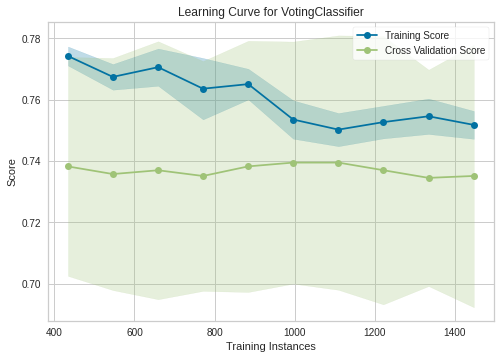

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [282]:
plot_model(final_model_custom, plot = 'learning', use_train_data = True)

# Woman / Man 분화

In [283]:
# A하고 B 둘 중에 하나만 들어가야할 것 같음. 둘이 사실상 같은 변수임

features = [
    #'SeedA', 'SeedB',
    'SeedDiff',
    #'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    #'GapAvgA', #'GapAvgB',
    'GapAvgDiff',
    #'FGDiff',
    #'FGA','FGB',
    'FG3Diff',
    #'FG3A','FG3B',
    #'FTDiff',
    #'FTA','FTB',
    #'TOmarginDiff',
    #'TOmarginA','TOmarginB',
    #'WinRatio_3yearsA', 'WinRatio_3yearsB',
    'WinRatio_3yearsDiff', 
    #'GapAvg_3yearsA', 'GapAvg_3yearsB',
    'GapAvg_3yearsDiff',
    #'AdjOA','AdjOB',
    #'AdjODiff',
    #'AdjDA', 'AdjDB',
    #'AdjDDiff',
    #'AdjEMA', 'AdjEMB',
    'AdjEMDiff',
    #'AdjEWPA','AdjEWPB',
    'AdjEWPDiff',
    #'LuckyA', 'LuckyB',
    #'LuckyDiff',
    #'TourneyY_3yearsA','TourneyY_3yearsB',
    'TourneyY_3yearsDiff',
    #'OEA','OB',
    'OEDiff',
    #'DA', 'DB',
    'DEDiff',
    #'EMA', 'EMB',
    'EMDiff',
    #'EWPA','EWPB',
    'EWPDiff',
    #'TopClassY_3yearsA','TopClassY_3yearsB',
    'TopClassY_3yearsDiff',
    #'ManY'
]

In [284]:
train_man = df[df['Season'] >= 2003][df[df['Season'] >= 2003]['TeamIdA'].astype('str').str.contains('^1',regex= True)]

train_woman = df[df['Season'] >= 2013][df[df['Season'] >= 2013]['TeamIdA'].astype('str').str.contains('^3',regex= True)]

test_man = df_test[df_test['TeamIdA'].astype('str').str.contains('^1',regex= True)]

test_woman = df_test[df_test['TeamIdA'].astype('str').str.contains('^3',regex= True)]

In [285]:
train_man

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,NumWinsA,NumLossesA,...,EWPDiff,PossessionDiff,ReboundPctDiff,AssistRateDiff,ScoreDiff,WinA,LuckyA,LuckyB,LuckyDiff,ManY
1455,2003,134,1421,92,1411,84,16,16,13.0,16.0,...,-0.147030,0.241081,-0.052508,-0.049796,8,1,0.045678,0.050372,-0.004694,1
1456,2003,136,1112,80,1436,51,1,16,25.0,3.0,...,0.212138,10.323027,-0.080120,0.011455,29,1,0.044356,0.018810,0.025546,1
1457,2003,136,1113,84,1272,71,10,7,18.0,11.0,...,-0.129444,-1.018262,0.026745,-0.056567,13,1,-0.012014,0.030956,-0.042970,1
1458,2003,136,1141,79,1166,73,11,6,23.0,6.0,...,-0.112848,2.561244,-0.001809,0.005290,6,1,0.092861,0.065697,0.027164,1
1459,2003,136,1143,76,1301,74,8,9,21.0,8.0,...,0.091319,3.299928,-0.010608,-0.016667,2,1,0.044663,0.011844,0.032819,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,2022,146,1274,50,1242,76,10,1,23.0,10.0,...,-0.123361,-2.134109,-0.088606,-0.033761,-26,0,0.057298,0.060497,-0.003199,1
2699,2022,146,1389,49,1314,69,15,8,18.0,11.0,...,-0.068963,-3.266568,-0.006278,-0.016859,-20,0,-0.000637,0.036984,-0.037620,1
2700,2022,152,1437,65,1242,81,2,1,26.0,7.0,...,-0.029020,-5.494691,-0.039357,-0.051692,-16,0,0.053866,0.060497,-0.006631,1
2701,2022,152,1181,77,1314,81,2,8,28.0,6.0,...,0.107356,-2.035782,-0.074110,0.026987,-4,0,0.025884,0.036984,-0.011100,1


In [286]:
train_df_man = pd.concat([train_man[features], train_man['WinA']],axis=1)

test_df_man = test_man[features]

train_df_woman = pd.concat([train_woman[features], train_woman['WinA']],axis=1)

test_df_woman = test_woman[features]

In [288]:
train_df_woman.corr()['WinA'].sort_values()

SeedDiff               -0.618814
DEDiff                 -0.296387
FG3Diff                 0.265406
WinRatioDiff            0.369164
EWPDiff                 0.399492
TourneyY_3yearsDiff     0.405322
AdjEWPDiff              0.409854
WinRatio_3yearsDiff     0.424838
OEDiff                  0.443482
EMDiff                  0.463390
AdjEMDiff               0.474649
GapAvgDiff              0.474762
GapAvg_3yearsDiff       0.491403
TopClassY_3yearsDiff    0.496057
WinA                    1.000000
Name: WinA, dtype: float64

## Man

In [289]:
from pycaret.classification import *

pd.options.display.float_format = None

clf_test_2 = setup(data=train_df_man,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=10,
                   normalize = True,
                   transformation = False,
                   pca = False,
                   feature_selection = False,
                   session_id = 4629,
                   silent=True,
                   #remove_outliers = True,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )

#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

,Description,Value
0,session_id,4629
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2418, 15)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', '

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7fbf051313a0>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

In [290]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)
#Brier score가 지나치게 높게 나오는데 CV에 따른 차이로 생각됨.

custom_model = compare_models(fold = 10, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge','qda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.7293,0.8245,0.7248,0.7291,0.7252,0.4585,0.4608,0.5083,0.1727,0.014
lda,Linear Discriminant Analysis,0.7282,0.8244,0.7248,0.7273,0.7243,0.4562,0.4583,0.5086,0.1729,0.008
gbc,Gradient Boosting Classifier,0.7128,0.8104,0.6997,0.7158,0.7063,0.4253,0.4271,0.5022,0.1752,0.188
catboost,CatBoost Classifier,0.7033,0.8062,0.6865,0.7066,0.6951,0.4063,0.4078,0.5103,0.1787,1.972
rf,Random Forest Classifier,0.6956,0.7967,0.6698,0.7019,0.6845,0.3908,0.3922,0.5239,0.1808,0.203
et,Extra Trees Classifier,0.7021,0.7923,0.6829,0.7053,0.6935,0.4039,0.4045,0.5319,0.1840,0.150
lightgbm,Light Gradient Boosting Machine,0.6809,0.7867,0.6591,0.6845,0.6705,0.3612,0.3625,0.5928,0.2041,0.823
ada,Ada Boost Classifier,0.6850,0.7917,0.6733,0.6855,0.6777,0.3697,0.3713,0.5987,0.2057,0.082
xgboost,Extreme Gradient Boosting,0.6903,0.7847,0.6770,0.6923,0.6830,0.3803,0.3822,0.6536,0.2157,0.160
knn,K Neighbors Classifier,0.6773,0.7406,0.6518,0.6820,0.6658,0.3540,0.3550,1.9415,0.2163,0.020


INFO:logs:create_model_container: 13
INFO:logs:master_model_container: 13
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4629, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_wei

In [291]:
# 가장 좋은 모델에 대해 튜닝

# tuned_top = [tune_model(i, optimize = 'Brier') for i in custom_model]

# # 가장 좋은 모델에 대해 튜닝

tuned_top = [tune_model(i, 
                        optimize = 'Brier',
                        choose_better = True,
                        search_library = 'scikit-optimize'
                        ) for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.6941,0.7899,0.7024,0.6860,0.6941,0.3883,0.3884,0.5325,0.1841
1,0.6941,0.7888,0.6429,0.7105,0.6750,0.3875,0.3892,0.5423,0.1859
2,0.6746,0.7941,0.5783,0.7059,0.6358,0.3468,0.3525,0.5373,0.1851
3,0.6864,0.7889,0.6867,0.6786,0.6826,0.3727,0.3727,0.5384,0.1864
4,0.7101,0.7880,0.7470,0.6889,0.7168,0.4208,0.4222,0.5380,0.1853
5,0.7811,0.8700,0.7470,0.7949,0.7702,0.5615,0.5625,0.4533,0.1490
6,0.7456,0.8266,0.7619,0.7356,0.7485,0.4912,0.4915,0.5009,0.1689
7,0.7101,0.8273,0.7262,0.7011,0.7135,0.4202,0.4205,0.5037,0.1703
8,0.7515,0.8403,0.6905,0.7838,0.7342,0.5026,0.5062,0.4834,0.1631


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 5
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.02186052365026507, loss='deviance',
                           max_depth=3, max_features=0.6232626405890187,
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.08007251532446513,
                           min_impurity_split=None, min_samples_leaf=4,
                           min_samples_split=3, min_weight_fraction_leaf=0.0,
                           n_estimators=162, n_iter_no_change=None,
                           presort='deprecated', random_state=4629,
                           subsample=0.24172649404378482, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:tune_model() succesfully completed............................

In [292]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top,
                              fold = 10,
                              optimize = 'Brier',
                              choose_better = True)

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.6882,0.7922,0.7143,0.6742,0.6936,0.3768,0.3775,0.5335,0.1853
1,0.7059,0.8016,0.6548,0.7237,0.6875,0.4110,0.4129,0.5355,0.1831
2,0.6864,0.7967,0.6024,0.7143,0.6536,0.3709,0.3754,0.5416,0.1876
3,0.7041,0.8006,0.6867,0.7037,0.6951,0.4078,0.4080,0.5306,0.1831
4,0.7219,0.7931,0.7470,0.7045,0.7251,0.4442,0.4450,0.5368,0.1845
5,0.8047,0.8794,0.7952,0.8049,0.8000,0.6093,0.6093,0.4436,0.1448
6,0.7574,0.8371,0.7262,0.7722,0.7485,0.5146,0.5155,0.4952,0.1659
7,0.7515,0.8465,0.8214,0.7188,0.7667,0.5034,0.5085,0.4862,0.1633
8,0.7337,0.8416,0.6548,0.7746,0.7097,0.4670,0.4726,0.4795,0.1617


INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         prio

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
0,Voting Classifier,0.7314,0.8241,0.7078,0.7543,0.7303,0.4633,0.4643,0.5075,0.1718


In [293]:
#최종 모델
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                               

In [294]:
#
import datetime

now = datetime.datetime.now()

save_model(final_model_custom, f"/content/Model_MAN_test_{datetime.datetime.now()}")

prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

man_predictions = predict_model(prep_pipe,
                                data=test_df_man,
                                raw_score=True)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                                           

Transformation Pipeline and Model Successfully Saved


INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=prep_pipe)
INFO:logs:Global variable: prep_pipe returned as Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem

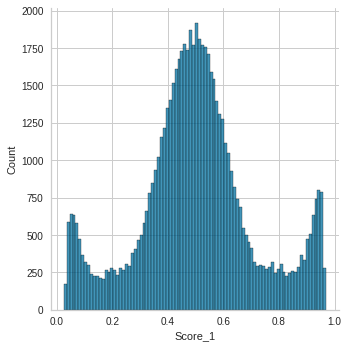

In [295]:
test_df_man_after_AutoML = test_df_man.copy()

test_df_man_after_AutoML['pred'] = man_predictions['Score_1']

_ = sns.displot(man_predictions['Score_1'])

In [296]:
def visualize_result(df,prep_pipe, types = None):

  if types == 'man':
    df = df[df['Season'] >= 2003][df[df['Season'] >= 2003]['TeamIdA'].astype('str').str.contains('^1',regex= True)]

  elif types == 'woman':
    df = df[df['Season'] >= 2013][df[df['Season'] >= 2013]['TeamIdA'].astype('str').str.contains('^3',regex= True)]

  else:
    pass

  for year in df['Season'].unique():      
      
    df_val = df[df['Season'] == year]

    df_val = df_val.reset_index(drop=True)

    prediction = prep_pipe.predict_proba(df_val[features])

    i, j = [], []
    for row in prediction:
      i.append(row[0])
      j.append(row[1])

    len(i), len(j)

    df_val['pred'] = j

    df_val['WinA_pred'] = prep_pipe.predict(df_val[features])
    
    #plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(1, 2,figsize = [12, 6])
    ax[0].set_ylim(-60, 60)
    ax[0].scatter(df_val['pred'], df_val['ScoreDiff'].values, s=10)
    ax[0].set_title('Prediction vs Score Diff')

    ax[1].hist(df_val['pred'], bins = 10, alpha = 0.4)
    ax[1].set_title('Predictions probability repartition')

    fig.suptitle(f'{year} Result', fontsize=16) # figure 제목

    fig.tight_layout() # 사용하면 플롯간 여백을 조정해준다. 
    plt.show()
    
    print(f'{year} Score : ', brier_score_loss(df_val['WinA'], df_val['pred']))

## woman

In [350]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

clf_test_3 = setup(data=train_df_woman,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=10,
                   normalize = True,
                   transformation = False,
                   pca = False,
                   feature_selection = False,
                   session_id = 123,
                   silent=True,
                   #remove_outliers = True,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )

#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

,Description,Value
0,session_id,123
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1140, 15)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', '

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7fbf051313a0>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

In [351]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)

custom_model = compare_models(fold = 10, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge','qda',
                                       #'et'
                                       ])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.7679,0.8681,0.7571,0.7706,0.7613,0.5354,0.5388,0.4452,0.1480,0.015
lda,Linear Discriminant Analysis,0.7804,0.8700,0.7674,0.7864,0.7734,0.5604,0.5650,0.4470,0.1489,0.008
et,Extra Trees Classifier,0.7566,0.8508,0.7469,0.7575,0.7500,0.5131,0.5159,0.4743,0.1583,0.112
catboost,CatBoost Classifier,0.7465,0.8505,0.7444,0.7485,0.7420,0.4931,0.4990,0.4750,0.1619,1.988
knn,K Neighbors Classifier,0.7553,0.8378,0.7419,0.7593,0.7484,0.5105,0.5133,1.2318,0.1658,0.021
rf,Random Forest Classifier,0.7403,0.8371,0.7394,0.7386,0.7361,0.4808,0.4843,0.4922,0.1661,0.162
gbc,Gradient Boosting Classifier,0.7415,0.8372,0.7417,0.7430,0.7381,0.4832,0.4888,0.4940,0.1691,0.094
lightgbm,Light Gradient Boosting Machine,0.7277,0.8208,0.7213,0.7282,0.7215,0.4554,0.4593,0.6505,0.2036,0.040
ada,Ada Boost Classifier,0.7303,0.8279,0.7164,0.7355,0.7211,0.4605,0.4660,0.5972,0.2047,0.056
xgboost,Extreme Gradient Boosting,0.7038,0.8123,0.6931,0.7068,0.6968,0.4077,0.4114,0.7218,0.2155,0.066


INFO:logs:create_model_container: 13
INFO:logs:master_model_container: 13
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimato

In [352]:
# 가장 좋은 모델에 대해 튜닝

#tuned_top = [tune_model(i, optimize = 'Brier') for i in custom_model]

tuned_top = [tune_model(i, 
                        optimize = 'Brier',
                        choose_better = True,
                        search_library = 'scikit-optimize'
                        ) for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.8125,0.8818,0.9231,0.7500,0.8276,0.6269,0.6432,0.4174,0.1389
1,0.8125,0.9350,0.7692,0.8333,0.8000,0.6241,0.6258,0.3852,0.1245
2,0.6750,0.7936,0.6154,0.6857,0.6486,0.3480,0.3497,0.5049,0.1779
3,0.7875,0.8374,0.8718,0.7391,0.8000,0.5766,0.5856,0.4981,0.1631
4,0.7000,0.8036,0.7692,0.6667,0.7143,0.4019,0.4064,0.5096,0.1795
5,0.7250,0.8443,0.7436,0.7073,0.7250,0.4503,0.4509,0.4509,0.1558
6,0.8125,0.9188,0.6750,0.9310,0.7826,0.6250,0.6501,0.3717,0.1209
7,0.7975,0.8712,0.8205,0.7805,0.8000,0.5951,0.5959,0.4439,0.1484
8,0.6456,0.8077,0.7179,0.6222,0.6667,0.2924,0.2958,0.4991,0.1755


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 5
INFO:logs:ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='entropy',
                     max_depth=7, max_features=0.7593961490586576,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=1.429531703022848e-06,
                     min_impurity_split=None, min_samples_leaf=2,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=104, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [353]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top,
                              fold = 10,
                              optimize = 'Brier',
                              choose_better = True,)

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.7875,0.8943,0.8462,0.7500,0.7952,0.5761,0.5806,0.4081,0.1349
1,0.8125,0.9356,0.7436,0.8529,0.7945,0.6236,0.6286,0.3652,0.1146
2,0.6875,0.8299,0.5897,0.7188,0.6479,0.3719,0.3777,0.4996,0.1725
3,0.8000,0.8543,0.8718,0.7556,0.8095,0.6012,0.6081,0.4718,0.1527
4,0.7000,0.8193,0.6923,0.6923,0.6923,0.3996,0.3996,0.5030,0.1756
5,0.7500,0.8568,0.7692,0.7317,0.7500,0.5003,0.5009,0.4615,0.1578
6,0.8125,0.9225,0.6750,0.9310,0.7826,0.6250,0.6501,0.3639,0.1152
7,0.7595,0.8673,0.7949,0.7381,0.7654,0.5194,0.5209,0.4492,0.1492
8,0.7215,0.8192,0.7436,0.7073,0.7250,0.4433,0.4439,0.5010,0.1746


INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.2684526873092069,
                                                 class_weight=None, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
0,Voting Classifier,0.8105,0.9003,0.8324,0.8098,0.8209,0.6198,0.62,0.3985,0.1298


In [354]:
#최종 모델
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.2684526873092069,
                                                 class_weight=None, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                      

In [355]:
#
import datetime

now = datetime.datetime.now()

save_model(final_model_custom, f"/content/Model_WOMAN_test_{datetime.datetime.now()}")

prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

woman_predictions = predict_model(prep_pipe,
                                data=test_df_woman,
                                raw_score=True)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.2684526873092069,
                                                 class_weight=None, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                  

Transformation Pipeline and Model Successfully Saved


INFO:logs:get_config(variable=prep_pipe)
INFO:logs:Global variable: prep_pipe returned as Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluste

In [356]:
train_df_woman['WinA'].value_counts()

1    570
0    570
Name: WinA, dtype: int64

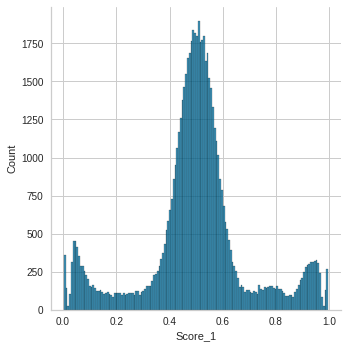

In [357]:
test_df_woman_after_AutoML = test_df_woman.copy()

test_df_woman_after_AutoML['pred'] = woman_predictions['Score_1']

_ = sns.displot(woman_predictions['Score_1'])

## 통합

In [358]:
test_df_2_after_AutoML = pd.concat([test_df_man_after_AutoML, test_df_woman_after_AutoML])

test_df_2_after_AutoML = pd.concat([test_df_2_after_AutoML, df_test['ID']],axis=1)

final_sub2 = test_df_2_after_AutoML[['ID','pred']].rename(columns ={'pred':'Pred'} )

In [359]:
final_sub2.to_csv('/content/submission_cross_0313.csv', index=False)

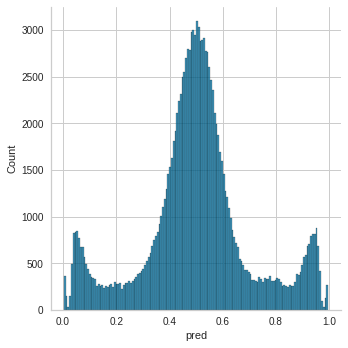

In [360]:
_ = sns.displot(test_df_2_after_AutoML['pred'])

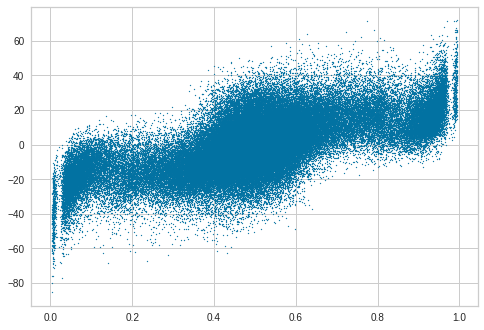

In [361]:
plt.scatter(final_sub2['Pred'],df_test['EMDiff'],s=1)

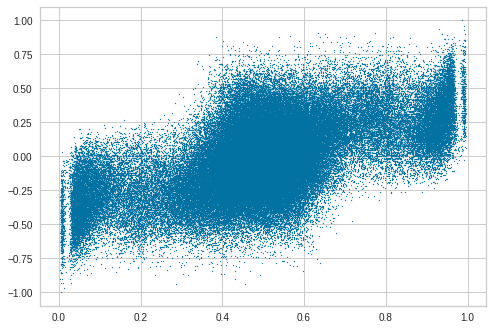

In [362]:
plt.scatter(final_sub2['Pred'],df_test['WinRatioDiff'],s=1)

### Brier Simulation

In [348]:
import pandas as pd
from scipy import stats

from ncaa_simulator import Data, Submission, Tournament, round_names

## load data
mw = 'W' # or 'W'
ncaa_data = Data(mw, dir='/content/Kaggle_Basketball/march-machine-learning-mania-2023_new')

sub_df = pd.read_csv('/content/submission_cross_0313.csv') # add your results as data to this notebook and edit this path to point to it

submission = Submission(sub_df=sub_df, data=ncaa_data)

season = 2023

tourney = Tournament(data=ncaa_data, submission=submission, season=season)

tourney.reset_tournament()

tourney.simulate_tournament(style='chalk') # this runs a chalk bracket where your predicted winner wins every game
# tourney.simulate_tournament(style='random',seed=123) # change the seed to get a different result

graph = tourney.graph_games()

graph.render('/content/Visual')

n_sim = 50

results, expected_losses = tourney.simulate_tournaments(n_sim=n_sim)

odds = results.copy()

odds.iloc[:,1:] = (results.iloc[:,1:]  / n_sim)

print(f'mean expected brier: {expected_losses.mean()} \n'
      f'standard dev brier: {expected_losses.std()} \n'
      f'standard error brier: {stats.sem(expected_losses)} \n')

odds.sort_values('Sweet 16', ascending=False).head(30)

mean expected brier: 0.15728304767936507 
standard dev brier: 0.02649256928856604 
standard error brier: 0.003784652755509434 



,Team,Play-in Games,First Round,Round of 32,Sweet 16,Elite 8,Final 4,Championship
TeamID,,,,,,,,
3376,W01 - South Carolina,0.0,0.96,0.92,0.80,0.76,0.40,0.30
3390,X01 - Stanford,0.0,0.98,0.80,0.66,0.52,0.38,0.26
3163,Z02 - Connecticut,0.0,0.96,0.72,0.64,0.52,0.42,0.20
3268,W02 - Maryland,0.0,0.96,0.74,0.54,0.12,0.02,0.02
3231,Y01 - Indiana,0.0,0.96,0.80,0.52,0.28,0.16,0.04
3439,Z01 - Virginia Tech,0.0,0.96,0.78,0.48,0.16,0.02,0.00
3181,X03 - Duke,0.0,0.96,0.56,0.44,0.14,0.08,0.06
3261,Y03 - LSU,0.0,0.98,0.58,0.38,0.24,0.08,0.00
3428,Y02 - Utah,0.0,0.96,0.68,0.36,0.12,0.04,0.00


# Baseline & Stacking

In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import optuna
import re
import sklearn

from optuna.visualization import plot_slice
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.tree import *
from sklearn.svm import SVC, LinearSVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [396]:
train_df_man = pd.concat([train_man[features], train_man['WinA']],axis=1)

test_df_man = test_man[features]

train_df_woman = pd.concat([train_woman[features], train_woman['WinA']],axis=1)

test_df_woman = test_woman[features]

## Man

In [397]:
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
train_df_man_scaled = pd.DataFrame(MinMaxScaler().fit_transform(train_df_man[features]))

### XGBOOST 

In [398]:
def objective(trial):
    xgb_params = dict(
        random_state=42,
        max_depth=trial.suggest_int("max_depth", 2, 32),
        learning_rate=trial.suggest_float("learning_rate", 0, 1),
        n_estimators=trial.suggest_int("n_estimators", 0,500,20),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1),
        colsample_bynode=trial.suggest_float("colsample_bynode", 0.01, 1),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.01, 1),
        max_delta_step=trial.suggest_int("max_delta_step", 1, 10),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e-1, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e0, 1e3, log=True),
        gamma=trial.suggest_float("gamma", 1e-6, 1, log=True)
        
    )
    return score_dataset(train_df_man_scaled, train_man['WinA'], xgb_params)

def score_dataset(X_scaled, y, xgb_params):
    
    classifier = xgb.XGBClassifier(**xgb_params)
    
    score = cross_val_score(classifier,
                            train_df_man_scaled, 
                            train_man['WinA'],
                            cv=ss,
                            #groups=groups, 
                            scoring='neg_brier_score')
    score = -1 * score.mean()
    return score

study = optuna.create_study()
study.optimize(objective, n_trials=50)
xgb_params = study.best_params
print(xgb_params)

plot_slice(study)

[I 2023-03-15 03:01:18,515] A new study created in memory with name: no-name-1ba801e6-b185-4fe2-ab29-e9eddd1ac36f
[I 2023-03-15 03:01:19,002] Trial 0 finished with value: 0.24003497945932278 and parameters: {'max_depth': 5, 'learning_rate': 0.007942267263247982, 'n_estimators': 77, 'min_child_weight': 2, 'colsample_bytree': 0.3705728199617008, 'colsample_bynode': 0.5866436458116787, 'colsample_bylevel': 0.3592061441888142, 'max_delta_step': 10, 'reg_alpha': 0.008984706843456243, 'reg_lambda': 531.3942439084985, 'gamma': 0.007206382908071225}. Best is trial 0 with value: 0.24003497945932278.
[I 2023-03-15 03:01:19,405] Trial 1 finished with value: 0.21807096789505498 and parameters: {'max_depth': 10, 'learning_rate': 0.8701440085892486, 'n_estimators': 45, 'min_child_weight': 4, 'colsample_bytree': 0.42805642842126346, 'colsample_bynode': 0.053607912485825256, 'colsample_bylevel': 0.8583686644610964, 'max_delta_step': 4, 'reg_alpha': 0.00024247787406034415, 'reg_lambda': 4.2030619478692

{'max_depth': 2, 'learning_rate': 0.2656532072014537, 'n_estimators': 75, 'min_child_weight': 6, 'colsample_bytree': 0.6032110789159633, 'colsample_bynode': 0.9581254724123831, 'colsample_bylevel': 0.6461524733834402, 'max_delta_step': 10, 'reg_alpha': 0.00038044601095988436, 'reg_lambda': 83.43371212905049, 'gamma': 3.4716951291832475e-05}


In [399]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

### LGBM

In [400]:
def objective(trial):
    lgbm_params = {
        "random_state":42,
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-6, 1e2, log=True),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e0, 1e3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 64),
        'learning_rate': trial.suggest_float("learning_rate", 0, .5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', .5, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', .5, 1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 80),
    }
    return score_dataset(train_df_man_scaled, train_man['WinA'], lgbm_params)

def score_dataset(X_scaled, y, lgbm_params):
    
    classifier = LGBMClassifier(**lgbm_params, class_weight='balanced')
    
    score = cross_val_score(classifier, train_df_man_scaled, train_man['WinA'].ravel(), cv=ss, scoring='neg_brier_score')
    score = -1 * score.mean()
    return score

study = optuna.create_study()
study.optimize(objective, n_trials=50)
lgbm_params = study.best_params
print(lgbm_params)

plot_slice(study)

[I 2023-03-15 03:02:05,828] A new study created in memory with name: no-name-b86d1494-02d9-40bc-999a-d9e899c88c0e
[I 2023-03-15 03:02:06,072] Trial 0 finished with value: 0.1740856569839524 and parameters: {'reg_alpha': 0.00799508718561924, 'reg_lambda': 228.21161325390563, 'num_leaves': 479, 'max_depth': 20, 'learning_rate': 0.1198976440085407, 'colsample_bytree': 0.9197780867444786, 'colsample_bynode': 0.758019292452148, 'n_estimators': 59}. Best is trial 0 with value: 0.1740856569839524.
[I 2023-03-15 03:02:06,398] Trial 1 finished with value: 0.2012748332562832 and parameters: {'reg_alpha': 0.0030446111088102737, 'reg_lambda': 2.7531816725554656, 'num_leaves': 973, 'max_depth': 29, 'learning_rate': 0.41027335550192773, 'colsample_bytree': 0.6121459192903268, 'colsample_bynode': 0.732599631829339, 'n_estimators': 31}. Best is trial 0 with value: 0.1740856569839524.
[I 2023-03-15 03:02:06,693] Trial 2 finished with value: 0.17200014176283965 and parameters: {'reg_alpha': 0.0003338024

{'reg_alpha': 0.0014716262212326077, 'reg_lambda': 1.8167960449108917, 'num_leaves': 162, 'max_depth': 2, 'learning_rate': 0.2795720206163575, 'colsample_bytree': 0.603458761543697, 'colsample_bynode': 0.8867833665193463, 'n_estimators': 21}


In [401]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

### Catboost

In [418]:
def objective(trial):
  catboost_params = {
      'learning_rate': trial.suggest_float('learning_rate', 0.01,0.5),
      'n_estimators': trial.suggest_int( "n_estimators",  0,500,20),
      'max_depth': trial.suggest_int( 'max_depth',  2,64,1),
      'l2_leaf_reg': trial.suggest_int('l2_leaf_reg',1,5,1),
      'random_state': trial.suggest_categorical('random_state',[42]),
      'loss_function': trial.suggest_categorical('loss_function',['CrossEntropy']),
      'eval_metric': trial.suggest_categorical('eval_metric',['F1']),
      'silent':trial.suggest_categorical('silent',[True]), 
      'early_stopping_rounds':trial.suggest_categorical('early_stopping_rounds',[100])}   

  return score_dataset(train_df_man_scaled, train_man['WinA'], catboost_params)

def score_dataset(X_scaled, y, catboost_params):

    classifier = CatBoostClassifier(**catboost_params)
    
    score = cross_val_score(classifier, 
                            train_df_man_scaled, 
                            train_man['WinA'].ravel(),
                            cv=ss, 
                            scoring='neg_brier_score')
    
    score = -1 * score.mean()

    return score

study = optuna.create_study()
study.optimize(objective, n_trials=50)
catboost_params = study.best_params
print(catboost_params)

plot_slice(study)

[I 2023-03-15 03:25:33,283] A new study created in memory with name: no-name-cc7db320-4042-4e12-9bdf-8102b7cbfeb0
[W 2023-03-15 03:25:33,304] Trial 0 failed with parameters: {'learning_rate': 0.3492028532862449, 'n_estimators': 360, 'max_depth': 48, 'l2_leaf_reg': 1, 'random_state': 42, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1', 'silent': True, 'early_stopping_rounds': 100} because of the following error: The value nan is not acceptable..
[W 2023-03-15 03:25:33,305] Trial 0 failed with value nan.
[W 2023-03-15 03:25:33,325] Trial 1 failed with parameters: {'learning_rate': 0.17570723948546357, 'n_estimators': 340, 'max_depth': 23, 'l2_leaf_reg': 4, 'random_state': 42, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1', 'silent': True, 'early_stopping_rounds': 100} because of the following error: The value nan is not acceptable..
[W 2023-03-15 03:25:33,326] Trial 1 failed with value nan.
[W 2023-03-15 03:25:33,343] Trial 2 failed with parameters: {'learning_rate': 0.4700544

KeyboardInterrupt: ignored

# Stacking

In [381]:
def standard_scale(features, df_train, df_val, df_test=None):    
    mm = MinMaxScaler() # This is preferred since our data is mostly normally distributed already. 
    
    df_train[features] = pd.DataFrame(mm.fit_transform(df_train[features]), columns = features)
    df_val[features] = pd.DataFrame(mm.transform(df_val[features]), columns = features)
    
    if df_test is not None:
        df_test[features] = pd.DataFrame(mm.transform(df_test[features]), columns = features)
    
    return df_train, df_val, df_test

In [384]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg",custom_features = None):
    seasons = df['Season'].unique()
    
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    features = custom_features
    
    for season in seasons[14:]:
        if verbose:
            print(f'\nValidating on season {season}')
        else:
            print(f'\nTesting on season {season}')
        
        current_season = int(season)
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.reset_index(drop=True).copy()
        
        df_train, df_val, df_test = standard_scale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            logistic = LogisticRegression(max_iter=10000, class_weight='balanced')
            lsvc = LinearSVC(C=100, max_iter=100000, class_weight='balanced') # I snuck this in because it did really well in validation testing.
            xgbc = xgb.XGBClassifier(**xgb_params)
            lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight='balanced')
            stacked = StackingClassifier(estimators=[
                                                     ('LinearSVC', lsvc),
                                                     ('XGBoost', xgbc),
                                                     ('LightGBM', lgbm)], final_estimator=logistic)
            model = stacked
            
        model.fit(df_train[features], df_train[target])
        calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        calibrated.fit(df_val[features], df_val[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = calibrated.predict_proba(df_val[features])[:, 1]
            
        if df_test is not None:
            if mode == "reg":
                pred = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = calibrated.predict_proba(df_test[features])[:, 1]
                # pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()

        if verbose:
            loss = ((df_val['WinA'].values - pred) ** 2).mean()
            cvs.append(loss)
            print(f'\t -> Scored {loss:.4f}')
        
    print(f'\n Local CV is {np.mean(cvs):.4f}')
    
    return pred_tests


Validating on season 2017


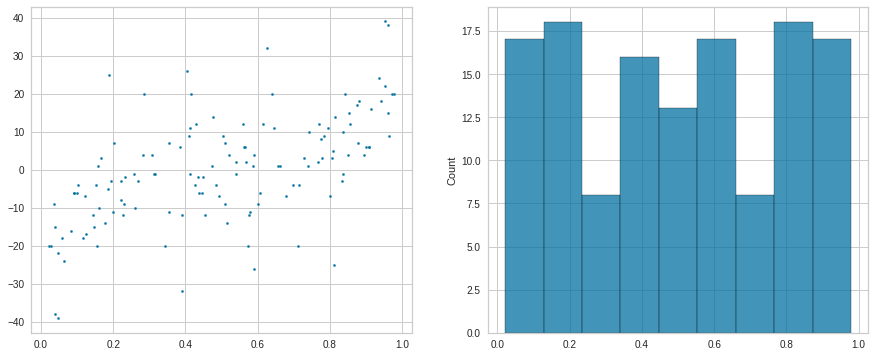

	 -> Scored 0.1655

Validating on season 2018


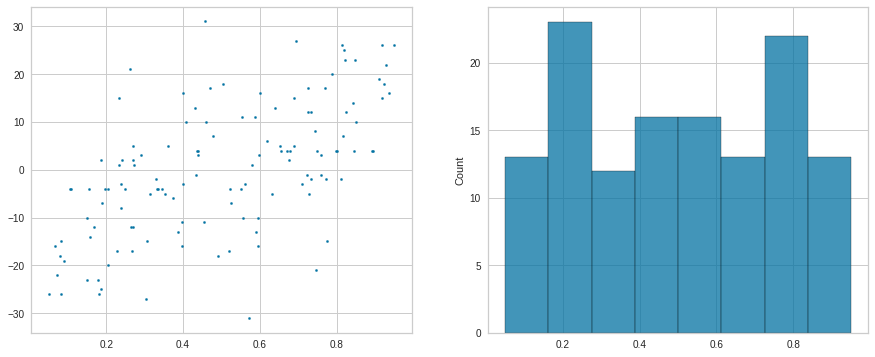

	 -> Scored 0.1835

Validating on season 2019


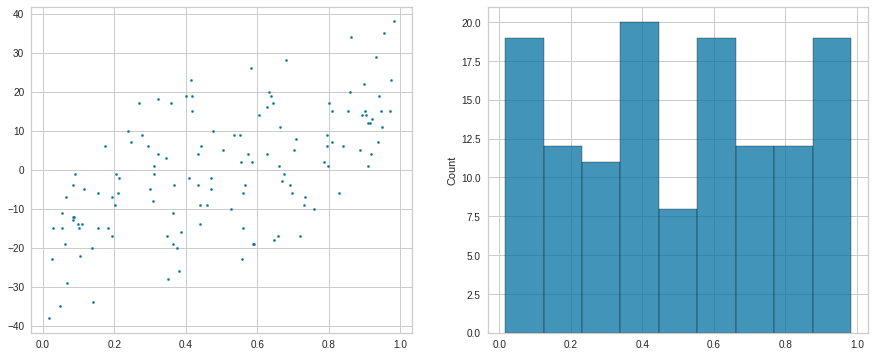

	 -> Scored 0.1679

Validating on season 2021


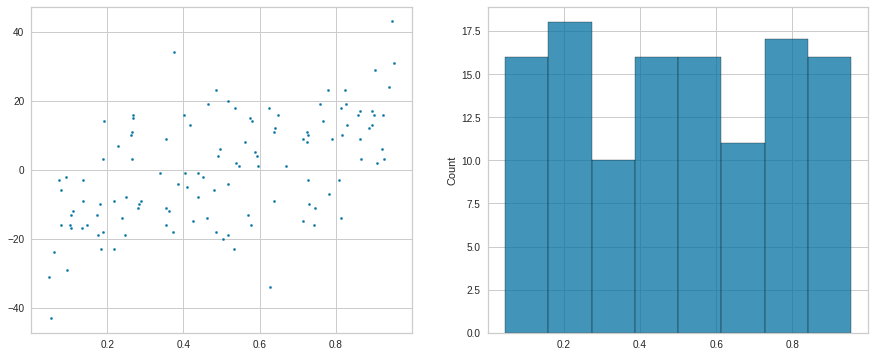

	 -> Scored 0.1759

Validating on season 2022


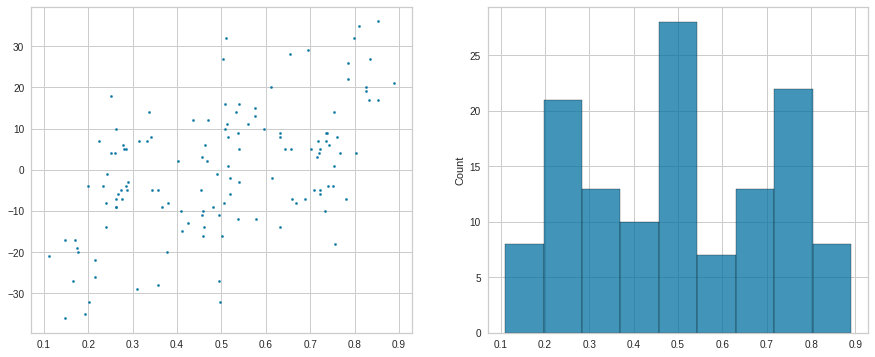

	 -> Scored 0.2063

 Local CV is 0.1798


In [388]:
pred_tests = kfold_reg(train_man, test_man, plot=True, verbose=1, mode="cls", custom_features = features)

In [ ]:
pred_test_man = np.mean(pred_tests, 0)